In [1]:
import numpy as np
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import sklearn as sk
import statsmodels.api as sm
import statsmodels.formula.api as smf
from math import sqrt
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Concatenate data from all subjects and all sessions
mycwd = os.getcwd()

path = r'/home/amoran/YASA/SWSdata/all'
os.chdir(path)
all_files = glob.glob("*.csv")
df_from_each_file = (pd.read_csv(f) for f in all_files)
newdf =  []
for i, dff in enumerate(df_from_each_file):
    dff['Group']= all_files[i][0]
    dff['Subject'] = all_files[i][0:3]
    dff['Session'] = all_files[i][4]
    newdf.append(dff)

os.chdir(mycwd)

# Construct dataframe
concatenated_df = pd.concat(newdf, ignore_index=True)
concatenated_df.rename(columns={'Unnamed: 0':'Wave'}, inplace=True)
concatenated_df.loc[:,'Session'] = concatenated_df['Session'].astype(int)
concatenated_df.loc[:,'Start'] = concatenated_df['Start']/3600

# Name channels
chan_list = ['Fp1', 'Fpz', 'Fp2', 'AF7', 'AFz', 'AF8', 'F7', 'F3','Fz', 'F4', 'F8', 'FT7', 'FC3', 'FCz', 'FC4', 'FT8', 
             'A1', 'T7', 'C5', 'C3', 'Cz', 'C4', 'C6', 'T8', 'A2', 'TP7', 'CP3', 'CPz', 'CP4', 'TP8', 'P7', 'P3', 'Pz', 
             'P4', 'P8', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'O1', 'Oz', 'O2']
for i in range(len(chan_list)):
    concatenated_df.loc[(concatenated_df.Channel == 'EEG ' + chan_list[i]), 'Channel'] = chan_list[i]

# Add age
age = pd.read_csv('/home/amoran/YASA/SWSdata/NMDA-age.csv', usecols = ['Subject','Session','Birthdate','Testdate','M/F'])
age.loc[:,('Birthdate','Testdate')] = age.loc[:,('Birthdate','Testdate')].apply(pd.to_datetime)
age['Age'] = ((age['Testdate']-age['Birthdate']).apply(lambda r:r.days))/365.25
age['Age'] = round(age['Age'],2)
concatenated_df = concatenated_df.merge(age[['Subject','Session','Age']], on = ['Subject','Session'])

# Old/New system
concatenated_df['Machine'] = 'O'

subj1 = ['C22','C23','C24','C25','E17','E18','E20','E21','E22','E24','E25','E26','E27','S15','S16','S17','S18','S19','S20','S21','S22']
subj2 = ['E18','E20','E22']
subj3 = ['E13','E16','E17','E18']
subj4 = ['C13','C14','C15','C16','C20','C21','C23','E09','E10','E11','E13','E14','E15','E16','E18','S07','S08','S11','S12']
concatenated_df.loc[(concatenated_df['Session']==1)&concatenated_df.Subject.isin(subj1), 'Machine'] = 'N'
concatenated_df.loc[(concatenated_df['Session']==2)&concatenated_df.Subject.isin(subj2), 'Machine'] = 'N'
concatenated_df.loc[(concatenated_df['Session']==3)&concatenated_df.Subject.isin(subj3), 'Machine'] = 'N'
concatenated_df.loc[(concatenated_df['Session']==4)&concatenated_df.Subject.isin(subj4), 'Machine'] = 'N'

# Normalize wave events
concatenated_df = concatenated_df.sort_values(by = ['Subject','Session','Start'])
concatenated_df['order'] = concatenated_df.groupby(['Subject','Session'])['Start'].rank(method = 'first').astype('int32')
scaler = MinMaxScaler() 
waveres= concatenated_df.groupby(['Subject','Session']).apply(lambda x: scaler.fit_transform(x[['order']].values.astype(float))).reset_index()

# Reformat data
waveres.rename(columns={0: 'res'}, inplace=True)
waveres = waveres.explode('res').reset_index()
waveres.loc[:,'res'] =waveres.res.astype('float')

# Add column with normalized events to dataframe
concatenated_df['WaveRes'] = waveres['res'].values

In [3]:
concatenated_df

,Wave,Start,NegPeak,MidCrossing,PosPeak,End,Duration,ValNegPeak,ValPosPeak,PTP,...,Stage,Channel,IdxChannel,Group,Subject,Session,Age,Machine,order,WaveRes
2819111,0,0.263417,948.93,949.21,949.37,949.52,1.22,-99.451261,40.264333,139.715594,...,2,Fp1,0,C,C02,1,22.91,O,1,0.0
2821183,2072,0.263503,948.91,949.11,949.34,949.54,0.93,-47.567302,57.325832,104.893134,...,2,Fpz,1,C,C02,1,22.91,O,2,0.000022
2842637,23526,0.390594,1406.61,1406.99,1407.54,1407.86,1.72,-41.000357,45.505349,86.505706,...,2,FT8,15,C,C02,1,22.91,O,3,0.000045
2843378,24267,0.390614,1406.66,1407.04,1407.50,1407.82,1.61,-62.808547,76.158474,138.967022,...,2,T7,17,C,C02,1,22.91,O,4,0.000067
2844194,25083,0.390683,1406.79,1407.17,1407.61,1407.90,1.44,-71.977917,63.284502,135.262419,...,2,C5,18,C,C02,1,22.91,O,5,0.00009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2376601,66872,7.985675,28748.68,28748.90,28749.12,28749.42,0.99,-60.382426,56.412705,116.795131,...,2,PO4,38,S,S22,1,18.30,N,69331,0.999942
2364194,54465,7.986847,28752.99,28753.25,28753.49,28753.86,1.21,-47.168157,36.646719,83.814876,...,2,CPz,27,S,S22,1,18.30,N,69332,0.999957
2370405,60676,7.986847,28753.01,28753.27,28753.51,28753.90,1.25,-49.500273,39.891287,89.391560,...,2,Pz,32,S,S22,1,18.30,N,69333,0.999971
2357699,47970,7.986858,28753.00,28753.25,28753.50,28753.87,1.18,-43.927471,38.041350,81.968821,...,2,C4,21,S,S22,1,18.30,N,69334,0.999986


In [4]:
concatenated_df.to_pickle('./concatenated_df_oct.pkl')
age.to_pickle('./age_oct.pkl')

In [5]:
# Subsets data
crs1 = concatenated_df['Session']==1
crs2 = concatenated_df['Session']==2
crs3 = concatenated_df['Session']==3
crs4 = concatenated_df['Session']==4

cri1 = concatenated_df['Group'] == 'C'
cri2 = concatenated_df['Group'] == 'E'
cri3 = concatenated_df['Group'] == 'S'
criC = cri1 & crs1
criE = cri2 & crs1
criS = cri3 & crs1

# Only data from session 1
data = concatenated_df[crs1]
# Add confusional arousals
cfsubj = ['E02','E03','E05','E06','E07','E16','E21','E22','C11','C12','C14','C18']
data['ConfArousal'] = 0
data.loc[concatenated_df.Subject.isin(cfsubj),'ConfArousal'] = 1
data.loc[:,'ConfArousal'] = data.loc[:,'ConfArousal'].astype('category')
# Data all groups sessions 1-4
data4 = concatenated_df[(crs1 | crs2 | crs3 | crs4)]
# Data encephalitis for 4 sessions
cridataE = cri1 & (crs1 | crs2 | crs3 | crs4)
dataE = concatenated_df[cridataE]

/tmp/ipykernel_3376881/2811139589.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['ConfArousal'] = 0


In [6]:
# select frontal and posterior channels
chan_fp = ['Fp1', 'Fpz', 'Fp2', 'AF7', 'AFz', 'AF8', 'F7', 'F3','Fz', 'F4', 'F8', 'P3', 'Pz', 'P4', 'PO7', 'PO3', 
           'POz', 'PO4', 'PO8', 'O1', 'Oz', 'O2']
data_fp = concatenated_df[concatenated_df.Channel.isin(chan_fp)]

# add column indicating whether frontal or posterior electrode
chan_p = ['P3', 'Pz', 'P4', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'O1', 'Oz', 'O2']

data_fp['Position'] = 'F'
data_fp.loc[data_fp.Channel.isin(chan_p),'Position'] = 'P'

data_fp.loc[:,'Session'] = data_fp.loc[:,'Session'].astype(int)

/tmp/ipykernel_3376881/2125642727.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_fp['Position'] = 'F'


In [7]:
# Subsets A/P data
crC = data_fp['Group'] == 'C'
crE = data_fp['Group'] == 'E'
crE1 = data_fp['Session'] == 1
crE2 = data_fp['Session'] == 2
crE3 = data_fp['Session'] == 3
crE4 = data_fp['Session'] == 4

data_fp1 = data_fp[crE1]
data4 = data_fp[(crE1 | crE2 | crE3 | crE4)]
dataE_fp = data_fp[crE & (crE1 | crE2 | crE3 | crE4)]
dataCE_fp = data_fp[(crE | crC) & (crE1 | crE2 | crE3 | crE4)]

## Check age

In [8]:
age.head()

,Subject,Session,Birthdate,Testdate,M/F,Age
0,C02,1,1994-05-28 00:00:00,2017-04-26 00:00:00,F,22.91
1,C03,1,1988-09-09 00:00:00,2017-05-18 00:00:00,F,28.69
2,C04,1,1987-05-24 00:00:00,2017-06-08 00:00:00,F,30.04
3,C06,1,2003-04-10 00:00:00,2017-06-22 00:00:00,F,14.20
4,C07,1,1994-06-05 00:00:00,2017-07-05 00:00:00,F,23.08


average age: 26.050588235294118
average age controls: 25.523043478260874
average age encephalitis: 28.807199999999998
average age schizophrenia: 23.2115


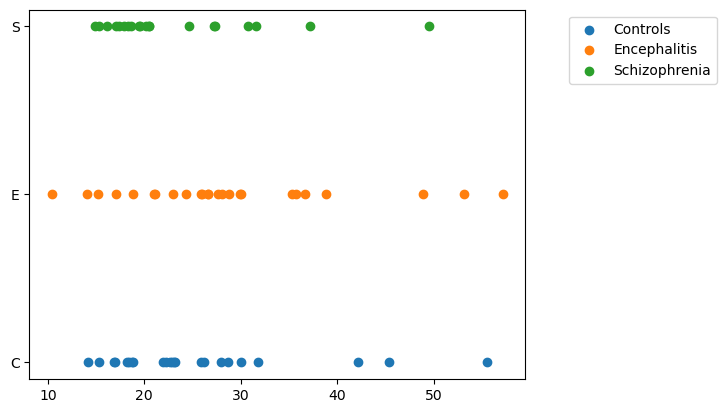

In [9]:
# Session 1

age['Group'] = age['Subject'].str[0]

print('average age:', np.mean(age.loc[age['Session']==1, 'Age']))
print('average age controls:', np.mean(age.loc[((age['Group']=='C')&(age['Session']==1)), 'Age']))
print('average age encephalitis:', np.mean(age.loc[((age['Group']=='E')&(age['Session']==1)), 'Age']))
print('average age schizophrenia:', np.mean(age.loc[((age['Group']=='S')&(age['Session']==1)), 'Age']))

# plot age
plt.scatter(age.loc[((age['Group']=='C')&(age['Session']==1)), 'Age'], age.loc[((age['Group']=='C')&(age['Session']==1)), 'Group'], label = 'Controls')
plt.scatter(age.loc[((age['Group']=='E')&(age['Session']==1)), 'Age'], age.loc[((age['Group']=='E')&(age['Session']==1)), 'Group'], label = 'Encephalitis')
plt.scatter(age.loc[((age['Group']=='S')&(age['Session']==1)), 'Age'], age.loc[((age['Group']=='S')&(age['Session']==1)), 'Group'], label = 'Schizophrenia')
plt.legend(bbox_to_anchor=(1.4, 1.0))

In [14]:


def fill_na_mode(group):
    mode = group.mode()
    if len(mode) > 0:
        return group.fillna(mode.iloc[0])
    else:
        return group

age['sex'] = age.groupby('Subject')['M/F'].transform(fill_na_mode)


In [13]:
age[age['Group']=='C']

,Subject,Session,Birthdate,Testdate,M/F,Age,Group,sex
0,C02,1,1994-05-28 00:00:00,2017-04-26 00:00:00,F,22.91,C,F
1,C03,1,1988-09-09 00:00:00,2017-05-18 00:00:00,F,28.69,C,F
2,C04,1,1987-05-24 00:00:00,2017-06-08 00:00:00,F,30.04,C,F
3,C06,1,2003-04-10 00:00:00,2017-06-22 00:00:00,F,14.20,C,F
4,C07,1,1994-06-05 00:00:00,2017-07-05 00:00:00,F,23.08,C,F
5,C08,1,1994-07-05 00:00:00,2017-08-31 00:00:00,M,23.16,C,M
6,C09,1,1995-07-03 00:00:00,2017-10-05 00:00:00,M,22.26,C,M
7,C10,1,1999-01-10 00:00:00,2017-10-19 00:00:00,F,18.77,C,F
8,C11,1,2001-02-03 00:00:00,2017-12-21 00:00:00,F,16.88,C,F
9,C12,1,2001-01-08 00:00:00,2017-12-21 00:00:00,F,16.95,C,F


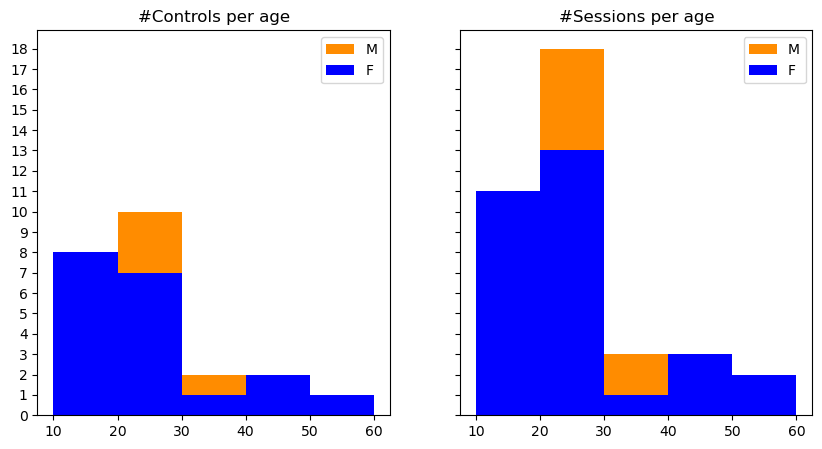

In [16]:
fig, ax = plt.subplots(1, 2, figsize = (10, 5), sharex = 'all', sharey = 'all')


ax[0].hist(age.loc[((age['Group']=='C')&(age['Session']==1)), 'Age'],color='darkorange',bins=[10, 20, 30, 40, 50, 60], label = 'M')
ax[0].hist(age.loc[((age['Group']=='C')&(age['Session']==1)&(age['sex']=='F')), 'Age'], color = 'blue',bins=[10, 20, 30, 40, 50, 60], label = 'F')
ax[0].set_yticks(np.arange(0, 20, step=1))
ax[0].legend()
ax[0].set_title('#Controls per age')

ax[1].hist(age.loc[((age['Group']=='C')), 'Age'],bins=[10, 20, 30, 40, 50, 60],color='darkorange', label = 'M')
ax[1].hist(age.loc[((age['Group']=='C')&(age['sex']=='F')), 'Age'], color = 'blue',bins=[10, 20, 30, 40, 50, 60], label = 'F')
ax[1].legend()
ax[1].set_title('#Sessions per age')

plt.show()



## Individual plots

In [ ]:
dataC11 = data[data['Subject']=='C11'].sort_values(by=['Start']).reset_index(drop=True)
dataC11['Time'] = pd.to_datetime(dataC11['Start'],unit = 'h')
dataC11 = dataC11.set_index('Time')
dataC11

,Wave,Start,NegPeak,MidCrossing,PosPeak,End,Duration,ValNegPeak,ValPosPeak,PTP,...,Channel,IdxChannel,Group,Subject,Session,Age,Machine,order,WaveRes,ConfArousal
Time,,,,,,,,,,,,,,,,,,,,,
1970-01-01 00:19:34.750000000,8285,0.326319,1174.97,1175.24,1175.54,1175.91,1.16,-58.165134,48.004513,106.169647,...,AF7,3,C,C11,1,16.88,O,1,0.0,1
1970-01-01 00:19:36.520000000,13626,0.326811,1176.82,1177.07,1177.24,1177.40,0.88,-71.782545,37.325789,109.108335,...,AF8,5,C,C11,1,16.88,O,2,0.000018,1
1970-01-01 00:20:07.510000000,5703,0.335419,1208.20,1208.44,1208.63,1208.83,1.32,-46.326606,31.601824,77.928431,...,Fp2,2,C,C11,1,16.88,O,3,0.000035,1
1970-01-01 00:20:55.569999999,8286,0.348769,1255.97,1256.37,1256.67,1256.96,1.39,-61.387916,31.949954,93.337870,...,AF7,3,C,C11,1,16.88,O,4,0.000053,1
1970-01-01 00:21:11.339999999,15831,0.353150,1271.89,1272.22,1272.54,1272.86,1.52,-41.785919,55.418799,97.204718,...,F7,6,C,C11,1,16.88,O,5,0.00007,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1970-01-01 08:41:39.420000000,52356,8.694283,31300.12,31300.35,31300.47,31300.56,1.14,-66.102320,25.395312,91.497632,...,Pz,32,C,C11,1,16.88,O,56927,0.99993,1
1970-01-01 08:41:46.020000000,56930,8.696117,31307.03,31307.33,31307.59,31307.88,1.86,-53.733592,58.592172,112.325764,...,O2,42,C,C11,1,16.88,O,56928,0.999947,1
1970-01-01 08:41:47.770000000,46957,8.696603,31308.00,31308.23,31308.52,31309.14,1.37,-47.716469,54.885270,102.601738,...,CP3,26,C,C11,1,16.88,O,56929,0.999965,1


In [ ]:
dataC11.Slope.rolling('1000s').mean()

Time
1970-01-01 00:19:34.750000000    393.220915
1970-01-01 00:19:36.520000000    414.827127
1970-01-01 00:20:07.510000000    384.785350
1970-01-01 00:20:55.569999999    346.925181
1970-01-01 00:21:11.339999999    336.452095
                                    ...    
1970-01-01 08:41:39.420000000    428.613663
1970-01-01 08:41:46.020000000    428.433015
1970-01-01 08:41:47.770000000    428.491691
1970-01-01 08:41:51.730000000    428.028331
1970-01-01 08:41:51.770000000    427.470469
Name: Slope, Length: 56931, dtype: float64

<Figure size 2500x500 with 0 Axes>

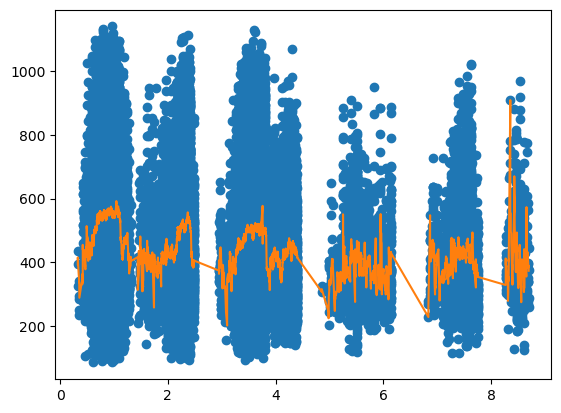

<Figure size 2500x500 with 0 Axes>

In [ ]:
rmean1 = dataC11.Slope.rolling('100s').mean()
plt.scatter(dataC11['Start'], dataC11['Slope'])
x, mean = zip(*sorted(zip(dataC11['Start'], rmean1),key=lambda x: x[0]))
plt.plot(x, mean, color='C1')
plt.figure(figsize=(25,5))

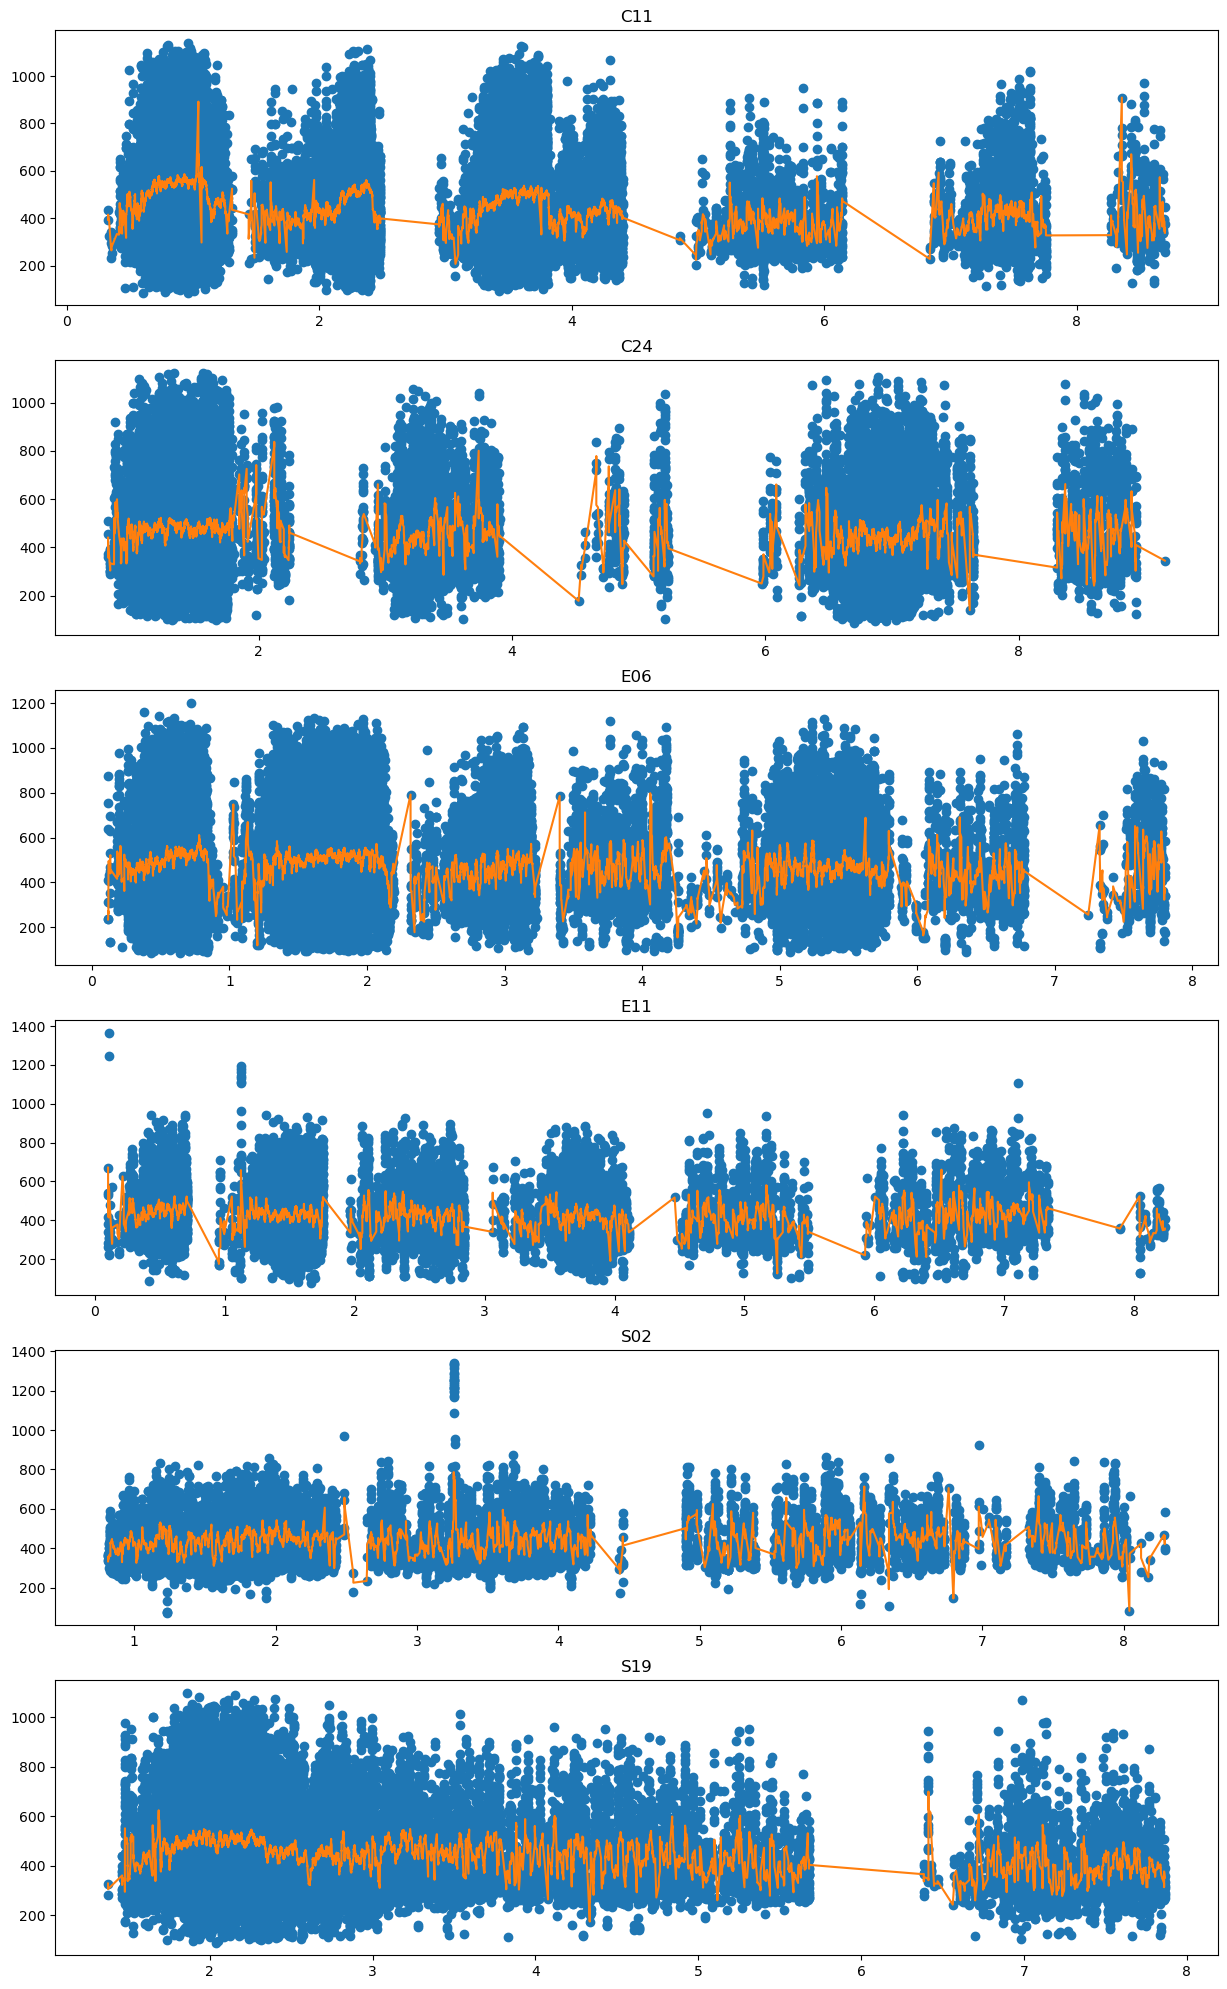

In [ ]:
fig, ax = plt.subplots(6, 1, figsize = (15, 25))

### DATA
dataC11 = data[data['Subject']=='C11'].sort_values(by=['Start']).reset_index(drop=True)
dataC11['Time'] = pd.to_datetime(dataC11['Start'],unit = 'h')
dataC11 = dataC11.set_index('Time')
rmean1 = dataC11.Slope.rolling('60s').mean()
dataC24 = data[data['Subject']=='C24'].sort_values(by=['Start']).reset_index(drop=True)
dataC24['Time'] = pd.to_datetime(dataC24['Start'],unit = 'h')
dataC24 = dataC24.set_index('Time')
rmean2 = dataC24.Slope.rolling('60s').mean()
dataE06 = data[data['Subject']=='E06'].sort_values(by=['Start']).reset_index(drop=True)
dataE06['Time'] = pd.to_datetime(dataE06['Start'],unit = 'h')
dataE06 = dataE06.set_index('Time')
rmean3 = dataE06.Slope.rolling('60s').mean()
dataE11 = data[data['Subject']=='E11'].sort_values(by=['Start']).reset_index(drop=True)
dataE11['Time'] = pd.to_datetime(dataE11['Start'],unit = 'h')
dataE11 = dataE11.set_index('Time')
rmean4 = dataE11.Slope.rolling('60s').mean()
dataS02 = data[data['Subject']=='S02'].sort_values(by=['Start']).reset_index(drop=True)
dataS02['Time'] = pd.to_datetime(dataS02['Start'],unit = 'h')
dataS02 = dataS02.set_index('Time')
rmean5 = dataS02.Slope.rolling('60s').mean()
dataS19 = data[data['Subject']=='S19'].sort_values(by=['Start']).reset_index(drop=True)
dataS19['Time'] = pd.to_datetime(dataS19['Start'],unit = 'h')
dataS19 = dataS19.set_index('Time')
rmean6 = dataS19.Slope.rolling('60s').mean()

# Plot individuals with running mean
ax[0].set_title('C11')
ax[0].scatter(dataC11['Start'], dataC11['Slope'])
x, mean = zip(*sorted(zip(dataC11['Start'], rmean1),key=lambda x: x[0]))
ax[0].plot(x, mean, color='C1')

ax[1].set_title('C24')
ax[1].scatter(dataC24['Start'], dataC24['Slope'])
x, mean = zip(*sorted(zip(dataC24['Start'], rmean2),key=lambda x: x[0]))
ax[1].plot(x, mean, color='C1')

ax[2].set_title('E06')
ax[2].scatter(dataE06['Start'], dataE06['Slope'])
x, mean = zip(*sorted(zip(dataE06['Start'], rmean3),key=lambda x: x[0]))
ax[2].plot(x, mean, color='C1')

ax[3].set_title('E11')
ax[3].scatter(dataE11['Start'], dataE11['Slope'])
x, mean = zip(*sorted(zip(dataE11['Start'], rmean4),key=lambda x: x[0]))
ax[3].plot(x, mean, color='C1')

ax[4].set_title('S02')
ax[4].scatter(dataS02['Start'], dataS02['Slope'])
x, mean = zip(*sorted(zip(dataS02['Start'], rmean5),key=lambda x: x[0]))
ax[4].plot(x, mean, color='C1')

ax[5].set_title('S19')
ax[5].scatter(dataS19['Start'], dataS19['Slope'])
x, mean = zip(*sorted(zip(dataS19['Start'], rmean6),key=lambda x: x[0]))
ax[5].plot(x, mean, color='C1')

# SLOPE

## All electrodes - all groups - session 1

In [ ]:
data['WaveRes10'] = data['WaveRes'] * 10
data.head(3)

/tmp/ipykernel_3351670/2640677986.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['WaveRes10'] = data['WaveRes'] * 10


,Wave,Start,NegPeak,MidCrossing,PosPeak,End,Duration,ValNegPeak,ValPosPeak,PTP,...,IdxChannel,Group,Subject,Session,Age,Machine,order,WaveRes,ConfArousal,WaveRes10
2819111,0,0.263417,948.93,949.21,949.37,949.52,1.22,-99.451261,40.264333,139.715594,...,0,C,C02,1,22.91,O,1,0.0,0,0.0
2821183,2072,0.263503,948.91,949.11,949.34,949.54,0.93,-47.567302,57.325832,104.893134,...,1,C,C02,1,22.91,O,2,0.000022,0,0.000225
2842637,23526,0.390594,1406.61,1406.99,1407.54,1407.86,1.72,-41.000357,45.505349,86.505706,...,15,C,C02,1,22.91,O,3,0.000045,0,0.00045


In [ ]:
# Mixed model with random intercept
mdl1 = smf.mixedlm('Slope ~ WaveRes10 * Group', data, groups = 'Subject')
mdl1f = mdl1.fit(reml=False) #powell, cg, bfgs, lbfgs.
mdl1f.summary()

KeyboardInterrupt: 

In [ ]:
# Mixed model with random intercept and random slope
mdl2 = smf.mixedlm('Slope ~ WaveRes10 * Group', data, groups = 'Subject', re_formula = '~ WaveRes10')
mdl2f = mdl2.fit(reml=False) #powell, cg, bfgs, lbfgs.
mdl2f.summary()

/home/kanthida/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/kanthida/anaconda3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2059: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Mixed Linear Model Regression Results
========================================================================
Model:                MixedLM     Dependent Variable:     Slope         
No. Observations:     3312902     Method:                 ML            
No. Groups:           63          Scale:                  77569.6634    
Min. group size:      2567        Likelihood:             -23351086.8356
Max. group size:      151841      Converged:              Yes           
Mean group size:      52585.7                                           
------------------------------------------------------------------------
                          Coef.   Std.Err.   z    P>|z|  [0.025   0.975]
------------------------------------------------------------------------
Intercept                 588.401   23.096 25.476 0.000  543.134 633.668
Group[T.E]                -62.906   33.055 -1.903 0.057 -127.693   1.881
Group[T.S]                  7.731   33.472  0.231 0.817  -57.873  73.335
WaveRes10                  -9.688    1.455 -6.657 0.000  -12.540  -6.836
WaveRes10:Group[T.E]        2.209    2.085  1.059 0.290   -1.878   6.296
WaveRes10:Group[T.S]        3.672    2.110  1.740 0.082   -0.464   7.808
Subject Var             11727.070    7.476                              
Subject x WaveRes10 Cov  -568.824    0.420                              
WaveRes10 Var              46.350    0.030                              
========================================================================

"""

In [ ]:
print(mdl1f.aic)
print(mdl2f.aic)

46719153.42080822
46702193.67115799


In [ ]:
mdl2f.save('Electrodes_Groups_S1_re.pickle')

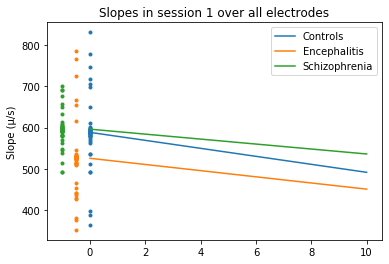

In [ ]:
# plot mixed model with random intercept and random slope

d = mdl2f.random_effects
dlist = []
for i in d: 
    dlist.append(d[i])

plt.plot(np.zeros(len(dlist[:22])), dlist[:22] + mdl2f.params.Intercept, marker = '.', linestyle='', color = 'C0' )
plt.plot(np.zeros(len(dlist[22:43]))-.5, dlist[22:43] + mdl2f.params.Intercept + mdl2f.params['Group[T.E]'], marker = '.', linestyle='', color = 'C1')
plt.plot(np.zeros(len(dlist[43:]))-1, dlist[43:] + mdl2f.params.Intercept + mdl2f.params['Group[T.S]'], marker = '.', linestyle='', color = 'C2')

X_plot = np.linspace(0,10,100)
plt.plot(X_plot, X_plot*mdl2f.params['WaveRes10'] + mdl2f.params.Intercept, label = 'Controls', color = 'C0')
plt.plot(X_plot, X_plot*(mdl2f.params['WaveRes10']+mdl2f.params['WaveRes10:Group[T.E]']) + mdl2f.params.Intercept + mdl2f.params['Group[T.E]'], label = 'Encephalitis', color = 'C1')
plt.plot(X_plot, X_plot*(mdl2f.params['WaveRes10']+mdl2f.params['WaveRes10:Group[T.S]']) + mdl2f.params.Intercept + mdl2f.params['Group[T.S]'], label = 'Schizophrenia', color = 'C2')
plt.legend()
plt.title('Slopes in session 1 over all electrodes')
plt.ylabel('Slope (μ/s)')
plt.show()

In [ ]:
mdl1f.save('model_all1.pickle')
mdl2f.save('model_all2.pickle') # did not converge

## All electrodes - encephalitis - session 1-4

In [ ]:
# Mixed model with random intercept
mdE3 = smf.mixedlm('Slope ~ WaveRes * Session', dataE, groups = 'Subject')
mdE3f = mdE3.fit(reml=False)
mdE3f.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
              Mixed Linear Model Regression Results
==================================================================
Model:              MixedLM   Dependent Variable:   Slope         
No. Observations:   1587090   Method:               ML            
No. Groups:         23        Scale:                79055.0031    
Min. group size:    18223     Likelihood:           -11201602.9890
Max. group size:    175862    Converged:            Yes           
Mean group size:    69003.9                                       
------------------------------------------------------------------
                 Coef.   Std.Err.    z     P>|z|  [0.025   0.975] 
------------------------------------------------------------------
Intercept        615.444   17.635   34.900 0.000  580.881  650.007
WaveRes         -139.013    1.313 -105.896 0.000 -141.586 -136.441
Session          -13.113    0.358  -36.618 0.000  -13.815  -12.411
WaveRes:Session   16.972    0.567   29.924 0.000   15.861   18.084
Subject Var     7137.702    7.134                                 
==================================================================

"""

In [ ]:
# Mixed model with random intercept and random slope
mdE4 = smf.mixedlm('Slope ~ WaveRes * Session', dataE, groups = 'Subject', re_formula = '~ WaveRes')
mdE4f = mdE4.fit(reml=False)
mdE4f.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Mixed Linear Model Regression Results
=======================================================================
Model:                 MixedLM    Dependent Variable:    Slope         
No. Observations:      1587090    Method:                ML            
No. Groups:            23         Scale:                 78745.3844    
Min. group size:       18223      Likelihood:            -11198547.9971
Max. group size:       175862     Converged:             Yes           
Mean group size:       69003.9                                         
-----------------------------------------------------------------------
                        Coef.   Std.Err.    z    P>|z|  [0.025   0.975]
-----------------------------------------------------------------------
Intercept               595.523   24.742  24.069 0.000  547.029 644.016
WaveRes                 -99.183   15.182  -6.533 0.000 -128.940 -69.427
Session                  -6.551    0.436 -15.041 0.000   -7.405  -5.697
WaveRes:Session           3.854    0.754   5.114 0.000    2.377   5.331
Subject Var           14060.315   16.395                               
Subject x WaveRes Cov -7463.466    9.817                               
WaveRes Var            5242.376    6.598                               
=======================================================================

"""

In [ ]:
mdE4f.save('Electrodes_E_S1-4.pickle')

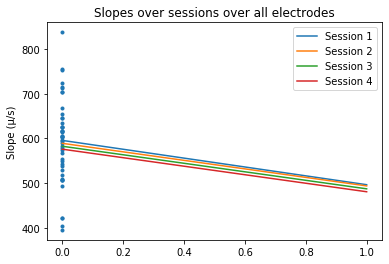

In [ ]:
# plot mixed model with random intercept and random slope

d = mdE4f.random_effects
dlist = []
for i in d: 
    dlist.append(d[i])

plt.plot(np.zeros(len(dlist)), dlist + mdE4f.params.Intercept, marker = '.', linestyle='', color = 'C0' )

X_plot = np.linspace(0,1,10)
plt.plot(X_plot, X_plot*mdE4f.params['WaveRes'] + mdE4f.params.Intercept, label = 'Session 1', color = 'C0')
plt.plot(X_plot, X_plot*(mdE4f.params['WaveRes']+mdE4f.params['WaveRes:Session']) + mdE4f.params.Intercept + mdE4f.params['Session'], label = 'Session 2', color = 'C1')
plt.plot(X_plot, X_plot*(mdE4f.params['WaveRes']+mdE4f.params['WaveRes:Session']) + mdE4f.params.Intercept + 2*mdE4f.params['Session'], label = 'Session 3', color = 'C2')
plt.plot(X_plot, X_plot*(mdE4f.params['WaveRes']+mdE4f.params['WaveRes:Session']) + mdE4f.params.Intercept + 3*mdE4f.params['Session'], label = 'Session 4', color = 'C3')
plt.legend()
plt.title('Slopes over sessions over all electrodes')
plt.ylabel('Slope (μ/s)')
plt.show()

# Anterior-Posterior

## A/P - all groups - session 1

In [ ]:
# Mixed model with random intercept
mdlfp1 = smf.mixedlm('Slope ~ WaveRes * Group * Position', data_fp1, groups = 'Subject')
mdlfp1f = mdlfp1.fit(reml=False)
mdlfp1f.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                       Mixed Linear Model Regression Results
===================================================================================
Model:                     MixedLM        Dependent Variable:        Slope         
No. Observations:          1971823        Method:                    ML            
No. Groups:                63             Scale:                     74367.2920    
Min. group size:           1899           Likelihood:                -13856891.0633
Max. group size:           88966          Converged:                 Yes           
Mean group size:           31298.8                                                 
-----------------------------------------------------------------------------------
                                  Coef.   Std.Err.    z     P>|z|  [0.025   0.975] 
-----------------------------------------------------------------------------------
Intercept                         694.524   20.184   34.410 0.000  654.964  734.084
Group[T.E]                        -84.659   28.886   -2.931 0.003 -141.275  -28.044
Group[T.S]                        -11.348   29.249   -0.388 0.698  -68.674   45.979
Position[T.P]                    -220.265    1.403 -156.964 0.000 -223.015 -217.515
Group[T.E]:Position[T.P]           46.811    2.078   22.532 0.000   42.739   50.883
Group[T.S]:Position[T.P]           39.979    1.927   20.742 0.000   36.201   43.756
WaveRes                          -165.782    1.422 -116.602 0.000 -168.569 -162.996
WaveRes:Group[T.E]                 13.587    2.113    6.430 0.000    9.446   17.729
WaveRes:Group[T.S]                 31.409    1.978   15.879 0.000   27.532   35.286
WaveRes:Position[T.P]              97.543    2.424   40.237 0.000   92.792  102.294
WaveRes:Group[T.E]:Position[T.P]  -12.050    3.589   -3.358 0.001  -19.084   -5.016
WaveRes:Group[T.S]:Position[T.P]   -3.402    3.330   -1.022 0.307   -9.928    3.124
Subject Var                      8946.901    5.992                                 
===================================================================================

"""

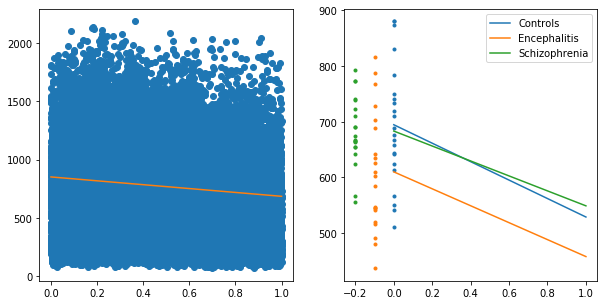

In [ ]:
d = mdlfp1f.random_effects
dlist = []
for i in d: 
    dlist.append(d[i])

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
dataC02 = data_fp1[data_fp1['Subject']=='E02']
plt.plot(dataC02['WaveRes'],dataC02['Slope'],'o')
X_plot = np.linspace(0,1,10)
plt.plot(X_plot, mdlfp1f.params.Intercept + np.array(mdlfp1f.random_effects['E02']) + X_plot*mdlfp1f.params['WaveRes'])

plt.subplot(1,2,2)

plt.plot(np.zeros(len(dlist[:22])), dlist[:22] + mdlfp1f.params.Intercept, marker = '.', linestyle='', color = 'C0')
plt.plot(np.zeros(len(dlist[22:43]))-.1, dlist[22:43] + mdlfp1f.params.Intercept+ mdlfp1f.params['Group[T.E]'], marker = '.', linestyle='', color = 'C1')
plt.plot(np.zeros(len(dlist[43:]))-.2, dlist[43:] + mdlfp1f.params.Intercept+ mdlfp1f.params['Group[T.S]'], marker = '.', linestyle='', color = 'C2')

plt.plot(X_plot, X_plot*mdlfp1f.params['WaveRes'] + mdlfp1f.params.Intercept, label = 'Controls', color = 'C0')
plt.plot(X_plot, X_plot*(mdlfp1f.params['WaveRes']+mdlfp1f.params['WaveRes:Group[T.E]']) + mdlfp1f.params.Intercept + mdlfp1f.params['Group[T.E]'], label = 'Encephalitis', color = 'C1')
plt.plot(X_plot, X_plot*(mdlfp1f.params['WaveRes']+mdlfp1f.params['WaveRes:Group[T.S]']) + mdlfp1f.params.Intercept + mdlfp1f.params['Group[T.S]'], label = 'Schizophrenia', color = 'C2')
plt.legend()
plt.show()

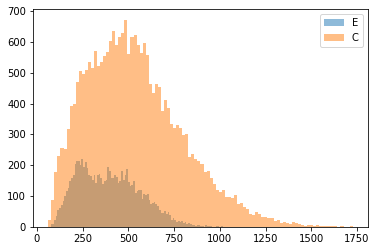

In [ ]:
dataC02 = data_fp1[data_fp1['Subject']=='E08']
plt.hist(dataC02['Slope'], bins=100,label='E', alpha=0.5);
dataC02 = data_fp1[data_fp1['Subject']=='C10']
plt.hist(dataC02['Slope'], bins=100, label='C', alpha=0.5);
plt.legend()

In [ ]:
# Mixed model with random intercept - Only anterior
mdlfp3 = smf.mixedlm('Slope ~ WaveRes * Group', data_fp1[data_fp1['Position']=='F'], groups = 'Subject')
mdlfp3f = mdlfp3.fit()
mdlfp3f.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                Mixed Linear Model Regression Results
======================================================================
Model:                 MixedLM    Dependent Variable:    Slope        
No. Observations:      1277083    Method:                REML         
No. Groups:            63         Scale:                 84179.0384   
Min. group size:       1400       Likelihood:            -9053834.4514
Max. group size:       53048      Converged:             Yes          
Mean group size:       20271.2                                        
----------------------------------------------------------------------
                     Coef.   Std.Err.    z     P>|z|  [0.025   0.975] 
----------------------------------------------------------------------
Intercept            689.095   23.056   29.888 0.000  643.906  734.284
Group[T.E]           -84.122   32.997   -2.549 0.011 -148.794  -19.450
Group[T.S]            -7.772   33.411   -0.233 0.816  -73.257   57.713
WaveRes             -165.782    1.513 -109.596 0.000 -168.747 -162.818
WaveRes:Group[T.E]    13.587    2.248    6.043 0.000    9.181   17.994
WaveRes:Group[T.S]    31.409    2.104   14.925 0.000   27.284   35.534
Subject Var        11676.495    7.451                                 
======================================================================

"""

In [ ]:
# Mixed model with random intercept - Only posterior
mdlfp4 = smf.mixedlm('Slope ~ WaveRes * Group', data_fp1[data_fp1['Position']=='P'], groups = 'Subject')
mdlfp4f = mdlfp4.fit()
mdlfp4f.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
              Mixed Linear Model Regression Results
==================================================================
Model:               MixedLM   Dependent Variable:   Slope        
No. Observations:    694740    Method:               REML         
No. Groups:          63        Scale:                54578.8874   
Min. group size:     499       Likelihood:           -4774892.9197
Max. group size:     37178     Converged:            Yes          
Mean group size:     11027.6                                      
------------------------------------------------------------------
                    Coef.   Std.Err.    z    P>|z|  [0.025  0.975]
------------------------------------------------------------------
Intercept           483.685   16.809  28.776 0.000 450.741 516.630
Group[T.E]          -36.022   24.064  -1.497 0.134 -83.186  11.142
Group[T.S]           23.216   24.361   0.953 0.341 -24.531  70.962
WaveRes             -68.239    1.682 -40.568 0.000 -71.536 -64.942
WaveRes:Group[T.E]    1.538    2.485   0.619 0.536  -3.333   6.408
WaveRes:Group[T.S]   28.007    2.295  12.205 0.000  23.509  32.504
Subject Var        6192.794    4.978                              
==================================================================

"""

In [ ]:
# Mixed model with random intercept and random slope
mdlfp2 = smf.mixedlm('Slope ~ WaveRes * Group * Position', data_fp1, groups = 'Subject', re_formula = '~ WaveRes')
mdlfp2f = mdlfp2.fit(reml=False) 
mdlfp2f.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                       Mixed Linear Model Regression Results
====================================================================================
Model:                    MixedLM         Dependent Variable:         Slope         
No. Observations:         1971823         Method:                     ML            
No. Groups:               63              Scale:                      73915.3566    
Min. group size:          1899            Likelihood:                 -13851023.9025
Max. group size:          88966           Converged:                  Yes           
Mean group size:          31298.8                                                   
------------------------------------------------------------------------------------
                                   Coef.   Std.Err.    z     P>|z|  [0.025   0.975] 
------------------------------------------------------------------------------------
Intercept                          680.912   26.481   25.713 0.000  629.010  732.815
Group[T.E]                         -92.381   37.901   -2.437 0.015 -166.665  -18.097
Group[T.S]                         -10.554   38.377   -0.275 0.783  -85.773   64.664
Position[T.P]                     -220.800    1.409 -156.718 0.000 -223.561 -218.038
Group[T.E]:Position[T.P]            41.462    2.086   19.874 0.000   37.373   45.551
Group[T.S]:Position[T.P]            35.736    1.935   18.467 0.000   31.943   39.529
WaveRes                           -138.563   16.431   -8.433 0.000 -170.767 -106.359
WaveRes:Group[T.E]                  29.010   23.546    1.232 0.218  -17.139   75.159
WaveRes:Group[T.S]                  29.782   23.820    1.250 0.211  -16.905   76.469
WaveRes:Position[T.P]               98.615    2.440   40.422 0.000   93.834  103.397
WaveRes:Group[T.E]:Position[T.P]    -1.356    3.612   -0.375 0.707   -8.436    5.724
WaveRes:Group[T.S]:Position[T.P]     5.075    3.351    1.515 0.130   -1.493   11.643
Subject Var                      15409.515   10.802                                 
Subject x WaveRes Cov            -7828.963    6.303                                 
WaveRes Var                       5884.903    4.332                                 
====================================================================================

"""

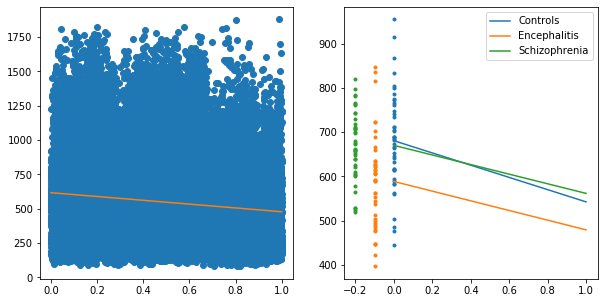

In [ ]:
d = mdlfp2f.random_effects
dlist = []
for i in d: 
    dlist.append(d[i])

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
dataC02 = data_fp1[data_fp1['Subject']=='C02']
plt.plot(dataC02['WaveRes'],dataC02['Slope'],'o')
X_plot = np.linspace(0,1,10)
plt.plot(X_plot, mdlfp2f.params.Intercept + np.array(mdlfp2f.random_effects['C02'][1]) + X_plot*mdlfp2f.params['WaveRes'])

plt.subplot(1,2,2)

plt.plot(np.zeros(len(dlist[:22])), dlist[:22] + mdlfp2f.params.Intercept, marker = '.', linestyle='', color = 'C0')
plt.plot(np.zeros(len(dlist[22:43]))-.1, dlist[22:43] + mdlfp2f.params.Intercept+ mdlfp2f.params['Group[T.E]'], marker = '.', linestyle='', color = 'C1')
plt.plot(np.zeros(len(dlist[43:]))-.2, dlist[43:] + mdlfp2f.params.Intercept+ mdlfp2f.params['Group[T.S]'], marker = '.', linestyle='', color = 'C2')

plt.plot(X_plot, X_plot*mdlfp2f.params['WaveRes'] + mdlfp2f.params.Intercept, label = 'Controls', color = 'C0')
plt.plot(X_plot, X_plot*(mdlfp2f.params['WaveRes']+mdlfp2f.params['WaveRes:Group[T.E]']) + mdlfp2f.params.Intercept + mdlfp2f.params['Group[T.E]'], label = 'Encephalitis', color = 'C1')
plt.plot(X_plot, X_plot*(mdlfp2f.params['WaveRes']+mdlfp2f.params['WaveRes:Group[T.S]']) + mdlfp2f.params.Intercept + mdlfp2f.params['Group[T.S]'], label = 'Schizophrenia', color = 'C2')
plt.legend()
plt.show()

In [ ]:
mdlfp2f.random_effects['C02']

Subject    86.328200
WaveRes   -63.958314
dtype: float64

In [ ]:
mdlfp2f.save('AP_Groups_S1.pickle')

In [ ]:
print(mdlfp1f.aic)
print(mdlfp2f.aic)

In [ ]:
# Anterior
mdlfp5 = smf.mixedlm('Slope ~ WaveRes * Group', data_fp1[data_fp1['Position']=='F'], groups = 'Subject', re_formula = '~ WaveRes')
mdlfp5f = mdlfp5.fit() 
mdlfp5f.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Mixed Linear Model Regression Results
=======================================================================
Model:                MixedLM     Dependent Variable:     Slope        
No. Observations:     1277083     Method:                 REML         
No. Groups:           63          Scale:                  83547.4580   
Min. group size:      1400        Likelihood:             -9049153.0766
Max. group size:      53048       Converged:              Yes          
Mean group size:      20271.2                                          
-----------------------------------------------------------------------
                        Coef.    Std.Err.   z    P>|z|  [0.025   0.975]
-----------------------------------------------------------------------
Intercept                672.342   31.272 21.500 0.000  611.050 733.633
Group[T.E]               -93.864   44.758 -2.097 0.036 -181.588  -6.141
Group[T.S]                -5.411   45.320 -0.119 0.905  -94.237  83.415
WaveRes                 -132.284   19.717 -6.709 0.000 -170.929 -93.638
WaveRes:Group[T.E]        33.043   28.256  1.169 0.242  -22.338  88.424
WaveRes:Group[T.S]        26.647   28.586  0.932 0.351  -29.381  82.674
Subject Var            21491.987   14.524                              
Subject x WaveRes Cov -11518.911    8.583                              
WaveRes Var             8485.743    5.808                              
=======================================================================

"""

In [ ]:
mdlfp5f.save('A_Groups_S1.pickle')

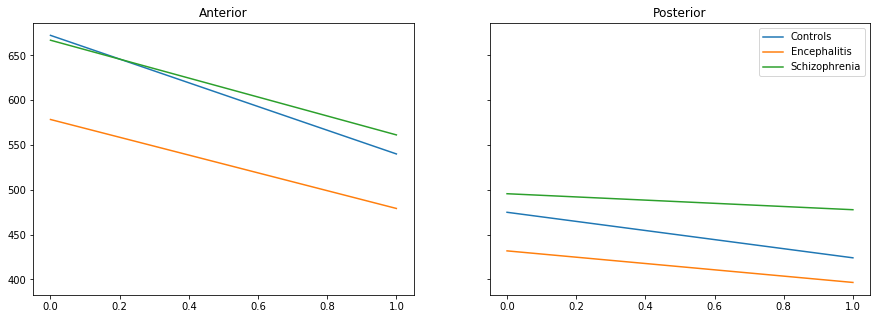

In [ ]:
# Plot
fig, ax = plt.subplots(1,2, figsize=(15,5), sharey=True)
X_plot = np.linspace(0,1,10)

# Anterior
ax[0].plot(X_plot, X_plot*mdlfp5f.params['WaveRes'] + mdlfp5f.params.Intercept, label = 'Controls', color = 'C0')
ax[0].plot(X_plot, X_plot*(mdlfp5f.params['WaveRes'] + mdlfp5f.params['WaveRes:Group[T.E]']) + mdlfp5f.params.Intercept + mdlfp5f.params['Group[T.E]'], label = 'Encephalitis', color = 'C1')
ax[0].plot(X_plot, X_plot*(mdlfp5f.params['WaveRes'] + mdlfp5f.params['WaveRes:Group[T.S]']) + mdlfp5f.params.Intercept + mdlfp5f.params['Group[T.S]'], label = 'Schizophrenia', color = 'C2')
ax[0].title.set_text('Anterior')
# Posterior
ax[1].plot(X_plot, X_plot*mdlfp6f.params['WaveRes'] + mdlfp6f.params.Intercept, label = 'Controls', color = 'C0')
ax[1].plot(X_plot, X_plot*(mdlfp6f.params['WaveRes'] + mdlfp6f.params['WaveRes:Group[T.E]']) + mdlfp6f.params.Intercept + mdlfp6f.params['Group[T.E]'], label = 'Encephalitis', color = 'C1')
ax[1].plot(X_plot, X_plot*(mdlfp6f.params['WaveRes'] + mdlfp6f.params['WaveRes:Group[T.S]']) + mdlfp6f.params.Intercept + mdlfp6f.params['Group[T.S]'], label = 'Schizophrenia', color = 'C2')
ax[1].title.set_text('Posterior')
plt.legend()

In [ ]:
# Posterior
mdlfp6 = smf.mixedlm('Slope ~ WaveRes * Group', data_fp1[data_fp1['Position']=='P'], groups = 'Subject', re_formula = '~ WaveRes')
mdlfp6f = mdlfp6.fit() 
mdlfp6f.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                Mixed Linear Model Regression Results
=====================================================================
Model:                MixedLM    Dependent Variable:    Slope        
No. Observations:     694740     Method:                REML         
No. Groups:           63         Scale:                 54257.1280   
Min. group size:      499        Likelihood:            -4772945.7417
Max. group size:      37178      Converged:             Yes          
Mean group size:      11027.6                                        
---------------------------------------------------------------------
                        Coef.   Std.Err.   z    P>|z|  [0.025  0.975]
---------------------------------------------------------------------
Intercept               474.961   19.493 24.366 0.000 436.756 513.166
Group[T.E]              -43.051   27.920 -1.542 0.123 -97.773  11.671
Group[T.S]               20.708   28.265  0.733 0.464 -34.690  76.106
WaveRes                 -50.794   12.454 -4.079 0.000 -75.204 -26.385
WaveRes:Group[T.E]       15.574   17.939  0.868 0.385 -19.585  50.734
WaveRes:Group[T.S]       32.954   18.119  1.819 0.069  -2.558  68.467
Subject Var            8329.791    6.391                             
Subject x WaveRes Cov -3207.204    3.353                             
WaveRes Var            3324.193    2.603                             
=====================================================================

"""

## A/P - encephalitis - session 1-4

In [ ]:
# Mixed model with random intercept
mdEfp = smf.mixedlm('Slope ~ WaveRes * Session * Position', dataE_fp, groups = 'Subject')
mdEfpf = mdEfp.fit()
mdEfpf.summary()

/home/kanthida/anaconda3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2115: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/home/kanthida/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1286: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))


<class 'statsmodels.iolib.summary2.Summary'>
"""
                     Mixed Linear Model Regression Results
================================================================================
Model:                    MixedLM       Dependent Variable:       Slope         
No. Observations:         1863786       Method:                   REML          
No. Groups:               21            Scale:                    73426.4975    
Min. group size:          11429         Likelihood:               -13085668.5329
Max. group size:          334678        Converged:                Yes           
Mean group size:          88751.7                                               
--------------------------------------------------------------------------------
                                Coef.   Std.Err.    z    P>|z|  [0.025   0.975] 
--------------------------------------------------------------------------------
Intercept                       592.301   59.143  10.015 0.000  476.383  708.218
Position[T.P]                  -154.419    1.952 -79.088 0.000 -158.246 -150.592
WaveRes                        -136.327    1.998 -68.218 0.000 -140.244 -132.410
WaveRes:Position[T.P]            71.457    3.379  21.150 0.000   64.835   78.079
Session                          14.161    0.445  31.839 0.000   13.289   15.033
Session:Position[T.P]            -9.694    0.735 -13.183 0.000  -11.136   -8.253
WaveRes:Session                  -9.803    0.757 -12.943 0.000  -11.288   -8.319
WaveRes:Session:Position[T.P]     7.248    1.273   5.694 0.000    4.753    9.743
Subject Var                   73426.498                                         
================================================================================

"""

In [ ]:
# Frontal
mdEfp1 = smf.mixedlm('Slope ~ WaveRes * Session', dataE_fp[dataE_fp['Position']=='F'], groups = 'Subject')
mdEfp1f = mdEfp1.fit()
mdEfp1f.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
              Mixed Linear Model Regression Results
==================================================================
Model:               MixedLM   Dependent Variable:   Slope        
No. Observations:    1203866   Method:               REML         
No. Groups:          21        Scale:                81705.0591   
Min. group size:     7650      Likelihood:           -8516684.1530
Max. group size:     206104    Converged:            Yes          
Mean group size:     57327.0                                      
------------------------------------------------------------------
                  Coef.   Std.Err.    z    P>|z|  [0.025   0.975] 
------------------------------------------------------------------
Intercept         588.453   25.422  23.147 0.000  538.626  638.280
WaveRes          -136.327    2.108 -64.669 0.000 -140.459 -132.195
Session            13.956    0.473  29.516 0.000   13.030   14.883
WaveRes:Session    -9.803    0.799 -12.269 0.000  -11.369   -8.237
Subject Var     13540.005   15.634                                
==================================================================

"""

In [ ]:
# Posterior
mdEfp2 = smf.mixedlm('Slope ~ WaveRes * Session', dataE_fp[dataE_fp['Position']=='P'], groups = 'Subject')
mdEfp2f = mdEfp2.fit()
mdEfp2f.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
             Mixed Linear Model Regression Results
===============================================================
Model:              MixedLM  Dependent Variable:  Slope        
No. Observations:   659920   Method:              REML         
No. Groups:         21       Scale:               56810.6485   
Min. group size:    3779     Likelihood:          -4548692.6558
Max. group size:    128574   Converged:           Yes          
Mean group size:    31424.8                                    
---------------------------------------------------------------
                 Coef.   Std.Err.    z    P>|z|  [0.025  0.975]
---------------------------------------------------------------
Intercept        447.233   20.509  21.807 0.000 407.036 487.429
WaveRes          -64.870    2.396 -27.071 0.000 -69.566 -60.173
Session            4.615    0.531   8.698 0.000   3.575   5.654
WaveRes:Session   -2.555    0.900  -2.840 0.005  -4.319  -0.792
Subject Var     8790.171   11.979                              
===============================================================

"""

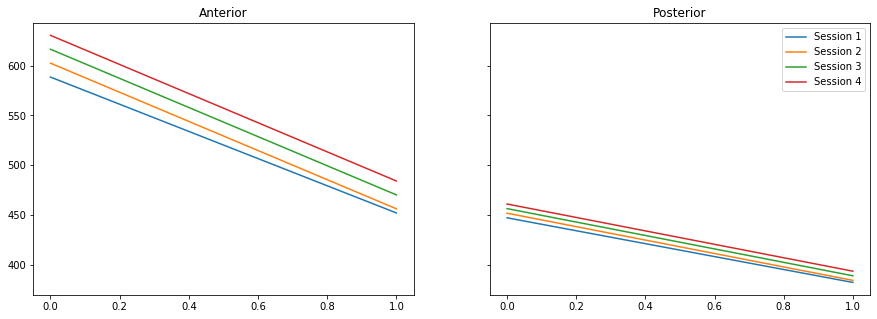

In [ ]:
# Plot
fig, ax = plt.subplots(1,2, figsize=(15,5), sharey=True)
X_plot = np.linspace(0,1,10)
# Anterior
ax[0].plot(X_plot, X_plot*mdEfp1f.params['WaveRes'] + mdEfp1f.params.Intercept, label = 'Session 1', color = 'C0')
ax[0].plot(X_plot, X_plot*(mdEfp1f.params['WaveRes'] + mdEfp1f.params['WaveRes:Session']) + mdEfp1f.params.Intercept + mdEfp1f.params['Session'], label = 'Session 2', color = 'C1')
ax[0].plot(X_plot, X_plot*(mdEfp1f.params['WaveRes'] + mdEfp1f.params['WaveRes:Session']) + mdEfp1f.params.Intercept + 2*mdEfp1f.params['Session'], label = 'Session 3', color = 'C2')
ax[0].plot(X_plot, X_plot*(mdEfp1f.params['WaveRes'] + mdEfp1f.params['WaveRes:Session']) + mdEfp1f.params.Intercept + 3*mdEfp1f.params['Session'], label = 'Session 4', color = 'C3')
ax[0].title.set_text('Anterior')
# Posterior
ax[1].plot(X_plot, X_plot*mdEfp2f.params['WaveRes'] + mdEfp2f.params.Intercept, label = 'Session 1', color = 'C0')
ax[1].plot(X_plot, X_plot*(mdEfp2f.params['WaveRes'] + mdEfp2f.params['WaveRes:Session']) + mdEfp2f.params.Intercept + mdEfp2f.params['Session'], label = 'Session 2', color = 'C1')
ax[1].plot(X_plot, X_plot*(mdEfp2f.params['WaveRes'] + mdEfp2f.params['WaveRes:Session']) + mdEfp2f.params.Intercept + 2*mdEfp2f.params['Session'], label = 'Session 3', color = 'C2')
ax[1].plot(X_plot, X_plot*(mdEfp2f.params['WaveRes'] + mdEfp2f.params['WaveRes:Session']) + mdEfp2f.params.Intercept + 3*mdEfp2f.params['Session'], label = 'Session 4', color = 'C3')
ax[1].title.set_text('Posterior')
plt.legend()

In [ ]:
# Mixed model with random intercept and random slope
mdEfp3 = smf.mixedlm('Slope ~ WaveRes * Session * Position', dataE_fp, groups = 'Subject', re_formula = '~ WaveRes')
mdEfp3f = mdEfp3.fit()
mdEfp3f.summary()

/home/kanthida/anaconda3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2115: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                     Mixed Linear Model Regression Results
================================================================================
Model:                    MixedLM       Dependent Variable:       Slope         
No. Observations:         1863786       Method:                   REML          
No. Groups:               21            Scale:                    72856.8322    
Min. group size:          11429         Likelihood:               -13078495.6584
Max. group size:          334678        Converged:                Yes           
Mean group size:          88751.7                                               
--------------------------------------------------------------------------------
                                Coef.   Std.Err.    z    P>|z|  [0.025   0.975] 
--------------------------------------------------------------------------------
Intercept                       570.960   58.914   9.691 0.000  455.491  686.428
Position[T.P]                  -162.573    1.949 -83.414 0.000 -166.393 -158.753
WaveRes                         -93.644   58.939  -1.589 0.112 -209.162   21.873
WaveRes:Position[T.P]            87.765    3.375  26.005 0.000   81.150   94.380
Session                          14.834    0.464  31.944 0.000   13.924   15.745
Session:Position[T.P]           -10.097    0.733 -13.769 0.000  -11.535   -8.660
WaveRes:Session                 -11.150    0.804 -13.864 0.000  -12.726   -9.574
WaveRes:Session:Position[T.P]     8.054    1.270   6.342 0.000    5.565   10.543
Subject Var                   72856.832                                         
Subject x WaveRes Cov             0.000                                         
WaveRes Var                   72856.832                                         
================================================================================

"""

In [ ]:
# Frontal - Mixed model with random intercept and random slope
mdEfp4 = smf.mixedlm('Slope ~ WaveRes * Session * Position', dataE_fp[dataE_fp['Position']=='F'], groups = 'Subject', re_formula = '~ WaveRes')
mdEfp4f = mdEfp4.fit()
mdEfp4f.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Mixed Linear Model Regression Results
========================================================================
Model:                 MixedLM     Dependent Variable:     Slope        
No. Observations:      1203866     Method:                 REML         
No. Groups:            21          Scale:                  80930.9076   
Min. group size:       7650        Likelihood:             -8510999.4657
Max. group size:       206104      Converged:              Yes          
Mean group size:       57327.0                                          
------------------------------------------------------------------------
                        Coef.    Std.Err.    z    P>|z|  [0.025   0.975]
------------------------------------------------------------------------
Intercept                563.285   35.475  15.878 0.000  493.755 632.815
WaveRes                  -86.000   20.409  -4.214 0.000 -126.002 -45.998
Session                   14.308    0.503  28.458 0.000   13.322  15.293
WaveRes:Session          -10.501    0.870 -12.069 0.000  -12.207  -8.796
Subject Var            26392.894   34.052                               
Subject x WaveRes Cov -14056.548   19.230                               
WaveRes Var             8641.306   11.495                               
========================================================================

"""

In [ ]:
mdEfp4f.save('A_Encephalitis_s1-4.pickle')

In [ ]:
# Posterior - Mixed model with random intercept and random slope
mdEfp5 = smf.mixedlm('Slope ~ WaveRes * Session * Position', dataE_fp[dataE_fp['Position']=='P'], groups = 'Subject', re_formula = '~ WaveRes')
mdEfp5f = mdEfp5.fit()
mdEfp5f.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                Mixed Linear Model Regression Results
=====================================================================
Model:                MixedLM    Dependent Variable:    Slope        
No. Observations:     659920     Method:                REML         
No. Groups:           21         Scale:                 56357.5782   
Min. group size:      3779       Likelihood:            -4546088.0193
Max. group size:      128574     Converged:             Yes          
Mean group size:      31424.8                                        
---------------------------------------------------------------------
                        Coef.   Std.Err.   z    P>|z|  [0.025  0.975]
---------------------------------------------------------------------
Intercept               427.793   26.078 16.404 0.000 376.681 478.905
WaveRes                 -25.962   14.282 -1.818 0.069 -53.953   2.030
Session                   5.197    0.559  9.305 0.000   4.102   6.292
WaveRes:Session          -3.716    0.966 -3.847 0.000  -5.610  -1.823
Subject Var           14231.766   18.932                             
Subject x WaveRes Cov -6779.943    9.711                             
WaveRes Var            4135.154    5.569                             
=====================================================================

"""

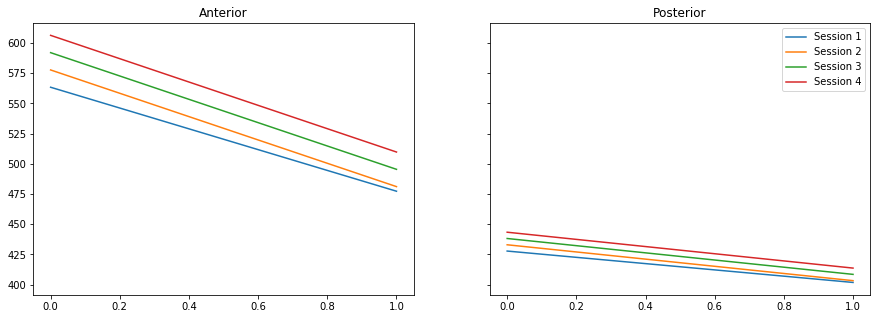

In [ ]:
# Plot
fig, ax = plt.subplots(1,2, figsize=(15,5), sharey=True)
X_plot = np.linspace(0,1,10)
# Anterior
ax[0].plot(X_plot, X_plot*mdEfp4f.params['WaveRes'] + mdEfp4f.params.Intercept, label = 'Session 1', color = 'C0')
ax[0].plot(X_plot, X_plot*(mdEfp4f.params['WaveRes'] + mdEfp4f.params['WaveRes:Session']) + mdEfp4f.params.Intercept + mdEfp4f.params['Session'], label = 'Session 2', color = 'C1')
ax[0].plot(X_plot, X_plot*(mdEfp4f.params['WaveRes'] + mdEfp4f.params['WaveRes:Session']) + mdEfp4f.params.Intercept + 2*mdEfp4f.params['Session'], label = 'Session 3', color = 'C2')
ax[0].plot(X_plot, X_plot*(mdEfp4f.params['WaveRes'] + mdEfp4f.params['WaveRes:Session']) + mdEfp4f.params.Intercept + 3*mdEfp4f.params['Session'], label = 'Session 4', color = 'C3')
ax[0].title.set_text('Anterior')
# Posterior
ax[1].plot(X_plot, X_plot*mdEfp5f.params['WaveRes'] + mdEfp5f.params.Intercept, label = 'Session 1', color = 'C0')
ax[1].plot(X_plot, X_plot*(mdEfp5f.params['WaveRes'] + mdEfp5f.params['WaveRes:Session']) + mdEfp5f.params.Intercept + mdEfp5f.params['Session'], label = 'Session 2', color = 'C1')
ax[1].plot(X_plot, X_plot*(mdEfp5f.params['WaveRes'] + mdEfp5f.params['WaveRes:Session']) + mdEfp5f.params.Intercept + 2*mdEfp5f.params['Session'], label = 'Session 3', color = 'C2')
ax[1].plot(X_plot, X_plot*(mdEfp5f.params['WaveRes'] + mdEfp5f.params['WaveRes:Session']) + mdEfp5f.params.Intercept + 3*mdEfp5f.params['Session'], label = 'Session 4', color = 'C3')
ax[1].title.set_text('Posterior')
plt.legend()

## Frontal - Controls & Encephalitis - Session 1-4

In [ ]:
# Mixed model with random intercept
mdCE = smf.mixedlm('Slope ~ WaveRes * Group * Session', dataCE_fp[dataCE_fp['Position']=='F'], groups = 'Subject')
mdCEf = mdCE.fit()
mdCEf.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                    Mixed Linear Model Regression Results
=============================================================================
Model:                   MixedLM      Dependent Variable:      Slope         
No. Observations:        1825000      Method:                  REML          
No. Groups:              44           Scale:                   83950.2025    
Min. group size:         7324         Likelihood:              -12935640.6964
Max. group size:         206104       Converged:               Yes           
Mean group size:         41477.3                                             
-----------------------------------------------------------------------------
                             Coef.   Std.Err.    z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------------------
Intercept                    711.327   24.006  29.632 0.000  664.277  758.377
Group[T.E]                  -122.873   34.743  -3.537 0.000 -190.968  -54.778
WaveRes                     -186.631    2.163 -86.295 0.000 -190.870 -182.393
WaveRes:Group[T.E]            50.304    3.040  16.546 0.000   44.346   56.263
Session                      -19.678    0.587 -33.505 0.000  -20.829  -18.527
Group[T.E]:Session            33.634    0.758  44.369 0.000   32.148   35.120
WaveRes:Session               20.849    0.935  22.300 0.000   19.017   22.682
WaveRes:Group[T.E]:Session   -30.653    1.237 -24.780 0.000  -33.077  -28.228
Subject Var                13214.096   10.311                                
=============================================================================

"""

In [ ]:
# Mixed model with random intercept and random slope
mdCE2 = smf.mixedlm('Slope ~ WaveRes * Group * Session', dataCE_fp[dataCE_fp['Position']=='F'], groups = 'Subject', re_formula = '~ WaveRes')
mdCE2f = mdCE2.fit()
mdCE2f.summary()

/home/kanthida/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/kanthida/anaconda3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2059: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
/home/kanthida/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/kanthida/anaconda3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2059: ConvergenceWarning: Retrying MixedLM optimization with cg
  ConvergenceWarning)
/home/kanthida/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals"

<class 'statsmodels.iolib.summary2.Summary'>
"""
                   Mixed Linear Model Regression Results
============================================================================
Model:                  MixedLM      Dependent Variable:      Slope         
No. Observations:       1825000      Method:                  REML          
No. Groups:             44           Scale:                   83268.2632    
Min. group size:        7324         Likelihood:              -12928361.1540
Max. group size:        206104       Converged:               No            
Mean group size:        41477.3                                             
----------------------------------------------------------------------------
                             Coef.   Std.Err.    z    P>|z|  [0.025   0.975]
----------------------------------------------------------------------------
Intercept                    687.984   27.615  24.913 0.000  633.860 742.109
Group[T.E]                  -124.672   39.963  -3.120 0.002 -202.998 -46.346
WaveRes                     -139.934   52.980  -2.641 0.008 -243.773 -36.094
WaveRes:Group[T.E]            53.895   76.674   0.703 0.482  -96.384 204.174
Session                      -12.572    0.707 -17.772 0.000  -13.959 -11.186
Group[T.E]:Session            26.898    0.872  30.836 0.000   25.188  28.607
WaveRes:Session                6.634    1.225   5.416 0.000    4.233   9.035
WaveRes:Group[T.E]:Session   -17.176    1.511 -11.371 0.000  -20.137 -14.216
Subject Var                17487.328   10.089                               
Subject x WaveRes Cov      11042.443    2.225                               
WaveRes Var                64402.990                                        
============================================================================

"""

In [ ]:
# Controls - Mixed model with random intercept and random slope
mdC = smf.mixedlm('Slope ~ WaveRes * Session', dataCE_fp[(dataCE_fp['Group']=='C') & (dataCE_fp['Position']=='F')], groups = 'Subject', re_formula = '~ WaveRes')
mdCf = mdC.fit()
mdCf.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Mixed Linear Model Regression Results
=========================================================================
Model:                  MixedLM     Dependent Variable:     Slope        
No. Observations:       621134      Method:                 REML         
No. Groups:             23          Scale:                  87798.8965   
Min. group size:        7324        Likelihood:             -4416603.5862
Max. group size:        68507       Converged:              Yes          
Mean group size:        27005.8                                          
-------------------------------------------------------------------------
                        Coef.    Std.Err.    z    P>|z|  [0.025   0.975] 
-------------------------------------------------------------------------
Intercept                687.974   32.911  20.904 0.000  623.469  752.479
WaveRes                 -139.956   19.150  -7.308 0.000 -177.489 -102.423
Session                  -12.573    0.724 -17.367 0.000  -13.992  -11.154
WaveRes:Session            6.650    1.250   5.319 0.000    4.199    9.100
Subject Var            24857.584   27.946                                
Subject x WaveRes Cov -13303.562   15.711                                
WaveRes Var             8270.889    9.420                                
=========================================================================

"""

In [ ]:
dataCf = dataCE_fp[(dataCE_fp['Group']=='C') & (dataCE_fp['Position']=='F')]
# Old/New system
dataCf.loc[:,'Machine'] = 'O'

subj1 = ['C22', 'C23', 'C24']
subj4 = ['C13', 'C15', 'C16']
dataCf.loc[(dataCf['Session']==1)&dataCf.Subject.isin(subj1), 'Machine'] = 'N'
dataCf.loc[(dataCf['Session']==4)&dataCf.Subject.isin(subj4), 'Machine'] = 'N'

In [ ]:
# Controls - Mixed model with random intercept and random slope
dataCf_corr = dataCf.copy(deep=True)
dataCf_corr['Slope'][dataCf_corr['Machine']=='N'] = dataCf_corr['Slope'][dataCf_corr['Machine']=='N']/0.871
mdC = smf.mixedlm('Slope ~ WaveRes * Session + WaveRes * Machine', dataCf_corr, groups = 'Subject', re_formula = '~ WaveRes')
mdCf = mdC.fit()
mdCf.summary()

/home/kanthida/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Mixed Linear Model Regression Results
=========================================================================
Model:                  MixedLM     Dependent Variable:     Slope        
No. Observations:       621134      Method:                 REML         
No. Groups:             23          Scale:                  93064.7089   
Min. group size:        7324        Likelihood:             -4434685.8708
Max. group size:        68507       Converged:              Yes          
Mean group size:        27005.8                                          
-------------------------------------------------------------------------
                        Coef.    Std.Err.    z    P>|z|  [0.025   0.975] 
-------------------------------------------------------------------------
Intercept                811.557   33.160  24.474 0.000  746.565  876.549
Machine[T.O]            -122.870    4.619 -26.601 0.000 -131.923 -113.817
WaveRes                 -136.175   20.332  -6.698 0.000 -176.025  -96.326
WaveRes:Machine[T.O]      -4.440    7.845  -0.566 0.571  -19.817   10.936
Session                  -16.025    0.906 -17.696 0.000  -17.800  -14.250
WaveRes:Session            4.758    1.552   3.065 0.002    1.716    7.801
Subject Var            24745.580   25.081                                
Subject x WaveRes Cov -12940.655   13.745                                
WaveRes Var             7934.277    8.111                                
=========================================================================

"""

In [ ]:
# Controls - Mixed model with random intercept and random slope
mdC = smf.mixedlm('Slope ~ WaveRes * Session', dataCf[dataCf['Machine']=='N'], groups = 'Subject', re_formula = '~ WaveRes')
mdCf = mdC.fit()
mdCf.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Mixed Linear Model Regression Results
=======================================================================
Model:                 MixedLM     Dependent Variable:     Slope       
No. Observations:      118085      Method:                 REML        
No. Groups:            6           Scale:                  87760.3679  
Min. group size:       12473       Likelihood:             -839611.1900
Max. group size:       27259       Converged:              Yes         
Mean group size:       19680.8                                         
-----------------------------------------------------------------------
                        Coef.    Std.Err.   z    P>|z|  [0.025   0.975]
-----------------------------------------------------------------------
Intercept                663.659  130.300  5.093 0.000  408.276 919.042
WaveRes                 -111.949   59.118 -1.894 0.058 -227.817   3.919
Session                   -8.249   44.692 -0.185 0.854  -95.844  79.347
WaveRes:Session            4.408   20.275  0.217 0.828  -35.330  44.147
Subject Var            26945.574   67.225                              
Subject x WaveRes Cov -12035.105   30.243                              
WaveRes Var             5492.052   13.793                              
=======================================================================

"""

In [ ]:
# Controls - Mixed model with random intercept and random slope
mdC = smf.mixedlm('Slope ~ WaveRes * Session', dataCf[dataCf['Machine']=='O'], groups = 'Subject', re_formula = '~ WaveRes')
mdCf = mdC.fit()
mdCf.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Mixed Linear Model Regression Results
=========================================================================
Model:                  MixedLM     Dependent Variable:     Slope        
No. Observations:       503049      Method:                 REML         
No. Groups:             20          Scale:                  87737.3992   
Min. group size:        7324        Likelihood:             -3576783.6077
Max. group size:        68507       Converged:              Yes          
Mean group size:        25152.5                                          
-------------------------------------------------------------------------
                        Coef.    Std.Err.    z    P>|z|  [0.025   0.975] 
-------------------------------------------------------------------------
Intercept                694.553   33.032  21.027 0.000  629.812  759.294
WaveRes                 -140.313   20.347  -6.896 0.000 -180.191 -100.434
Session                  -15.892    0.889 -17.873 0.000  -17.634  -14.149
WaveRes:Session            4.444    1.536   2.893 0.004    1.433    7.454
Subject Var            21760.703   25.129                                
Subject x WaveRes Cov -11959.773   14.552                                
WaveRes Var             8096.764    9.277                                
=========================================================================

"""

In [ ]:
# Controls - Mixed model with random intercept and random slope
dataCf_corr = dataCf.copy(deep=True)
dataCf_corr['Slope'][dataCf_corr['Machine']=='N'] = dataCf_corr['Slope'][dataCf_corr['Machine']=='N']*1.25
mdC = smf.mixedlm('Slope ~ WaveRes * Machine', dataCf_corr, groups = 'Subject', re_formula = '~ WaveRes')
mdCf = mdC.fit()
mdCf.summary()

/home/kanthida/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Mixed Linear Model Regression Results
=========================================================================
Model:                  MixedLM     Dependent Variable:     Slope        
No. Observations:       621134      Method:                 REML         
No. Groups:             23          Scale:                  97274.6443   
Min. group size:        7324        Likelihood:             -4448429.5179
Max. group size:        68507       Converged:              Yes          
Mean group size:        27005.8                                          
-------------------------------------------------------------------------
                        Coef.    Std.Err.    z    P>|z|  [0.025   0.975] 
-------------------------------------------------------------------------
Intercept                808.590   35.544  22.749 0.000  738.924  878.255
Machine[T.O]            -138.202    3.880 -35.616 0.000 -145.807 -130.597
WaveRes                 -125.220   20.453  -6.122 0.000 -165.308  -85.132
WaveRes:Machine[T.O]     -10.231    6.633  -1.542 0.123  -23.231    2.770
Subject Var            28820.291   30.720                                
Subject x WaveRes Cov -14952.599   16.540                                
WaveRes Var             8925.642    9.503                                
=========================================================================

"""

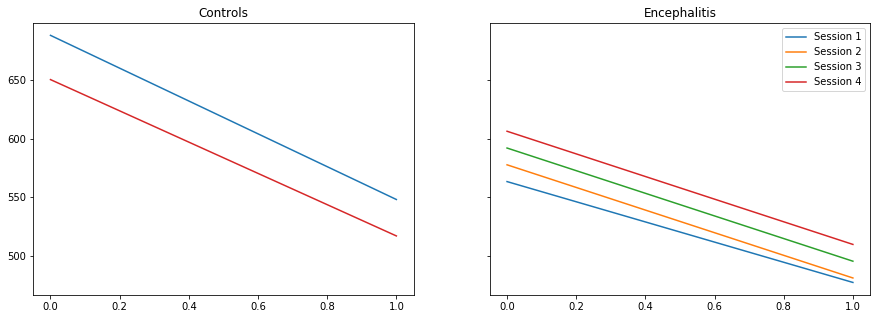

In [ ]:
# Plot controls vs encephalitis
fig, ax = plt.subplots(1,2, figsize=(15,5), sharey=True)
X_plot = np.linspace(0,1,10)
# Controls
ax[0].plot(X_plot, X_plot*mdCf.params['WaveRes'] + mdCf.params.Intercept, label = 'Session 1', color = 'C0')
ax[0].plot(X_plot, X_plot*(mdCf.params['WaveRes'] + mdCf.params['WaveRes:Session']) + mdCf.params.Intercept + 3*mdCf.params['Session'], label = 'Session 4', color = 'C3')
ax[0].title.set_text('Controls')
# Encephalitis
ax[1].plot(X_plot, X_plot*mdEfp4f.params['WaveRes'] + mdEfp4f.params.Intercept, label = 'Session 1', color = 'C0')
ax[1].plot(X_plot, X_plot*(mdEfp4f.params['WaveRes'] + mdEfp4f.params['WaveRes:Session']) + mdEfp4f.params.Intercept + mdEfp4f.params['Session'], label = 'Session 2', color = 'C1')
ax[1].plot(X_plot, X_plot*(mdEfp4f.params['WaveRes'] + mdEfp4f.params['WaveRes:Session']) + mdEfp4f.params.Intercept + 2*mdEfp4f.params['Session'], label = 'Session 3', color = 'C2')
ax[1].plot(X_plot, X_plot*(mdEfp4f.params['WaveRes'] + mdEfp4f.params['WaveRes:Session']) + mdEfp4f.params.Intercept + 3*mdEfp4f.params['Session'], label = 'Session 4', color = 'C3')
ax[1].title.set_text('Encephalitis')

plt.legend()

In [ ]:
mdCE2f.save('A_CE_S1-4.pickle')

# AMPLITUDE

## All electrodes - all groups - session 1

In [ ]:
# Mixed model with random intercept
mdl5 = smf.mixedlm('ValNegPeak ~ WaveRes * Group', data, groups = 'Subject')
mdl5f = mdl5.fit()
mdl5f.summary()

/home/kanthida/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/kanthida/anaconda3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2059: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM  Dependent Variable:  ValNegPeak    
No. Observations:    3312902  Method:              REML          
No. Groups:          63       Scale:               793.9372      
Min. group size:     2567     Likelihood:          -15761191.4734
Max. group size:     151841   Converged:           Yes           
Mean group size:     52585.7                                     
-----------------------------------------------------------------
                    Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          -76.044    1.849 -41.119 0.000 -79.668 -72.419
Group[T.E]           4.040    2.647   1.526 0.127  -1.147   9.227
Group[T.S]           1.139    2.680   0.425 0.671  -4.114   6.392
WaveRes              3.792    0.092  41.266 0.000   3.612   3.972
WaveRes:Group[T.E]   3.795    0.135  28.016 0.000   3.529   4.060
WaveRes:Group[T.S]  -0.454    0.127  -3.569 0.000  -0.704  -0.205
Subject Var         75.175    0.599                              
=================================================================

"""

In [ ]:
# Mixed model with random intercept and random slope
mdl6 = smf.mixedlm('ValNegPeak ~ WaveRes * Group', data, groups = 'Subject', re_formula = '~ WaveRes')
mdl6f = mdl6.fit()
mdl6f.summary()

/home/kanthida/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/kanthida/anaconda3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2059: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
/home/kanthida/anaconda3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2115: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/home/kanthida/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1286: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))


<class 'statsmodels.iolib.summary2.Summary'>
"""
               Mixed Linear Model Regression Results
====================================================================
Model:                MixedLM   Dependent Variable:   ValNegPeak    
No. Observations:     3312902   Method:               REML          
No. Groups:           63        Scale:                790.0166      
Min. group size:      2567      Likelihood:           -15753204.1230
Max. group size:      151841    Converged:            Yes           
Mean group size:      52585.7                                       
--------------------------------------------------------------------
                       Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
--------------------------------------------------------------------
Intercept             -75.215    2.261 -33.268 0.000 -79.646 -70.783
Group[T.E]              5.633    3.236   1.741 0.082  -0.709  11.976
Group[T.S]              1.461    3.277   0.446 0.656  -4.961   7.883
WaveRes                 2.135    2.994   0.713 0.476  -3.733   8.002
WaveRes:Group[T.E]      0.607    4.285   0.142 0.887  -7.792   9.007
WaveRes:Group[T.S]     -1.099    4.339  -0.253 0.800  -9.603   7.406
Subject Var           112.370    0.871                              
Subject x WaveRes Cov  30.917    0.466                              
WaveRes Var           196.936                                       
====================================================================

"""

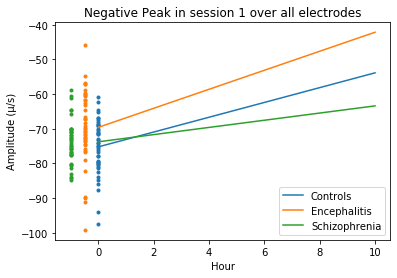

In [ ]:
# plot mixed model with random intercept and random slope

d = mdl6f.random_effects
dlist = []
for i in d: 
    dlist.append(d[i])

plt.plot(np.zeros(len(dlist[:22])), dlist[:22] + mdl6f.params.Intercept, marker = '.', linestyle='', color = 'C0' )
plt.plot(np.zeros(len(dlist[22:43]))-.5, dlist[22:43] + mdl6f.params.Intercept + mdl6f.params['Group[T.E]'], marker = '.', linestyle='', color = 'C1')
plt.plot(np.zeros(len(dlist[43:]))-1, dlist[43:] + mdl6f.params.Intercept + mdl6f.params['Group[T.S]'], marker = '.', linestyle='', color = 'C2')

X_plot = np.linspace(0,10,10)
plt.plot(X_plot, X_plot*mdl6f.params['WaveRes'] + mdl6f.params.Intercept, label = 'Controls', color = 'C0')
plt.plot(X_plot, X_plot*(mdl6f.params['WaveRes']+mdl6f.params['WaveRes:Group[T.E]']) + mdl6f.params.Intercept + mdl6f.params['Group[T.E]'], label = 'Encephalitis', color = 'C1')
plt.plot(X_plot, X_plot*(mdl6f.params['WaveRes']+mdl6f.params['WaveRes:Group[T.S]']) + mdl6f.params.Intercept + mdl6f.params['Group[T.S]'], label = 'Schizophrenia', color = 'C2')
plt.legend()
plt.title('Negative Peak in session 1 over all electrodes')
plt.xlabel('Hour')
plt.ylabel('Amplitude (μ/s)')
plt.show()

## A/P - all groups - session 1

In [ ]:
# Mixed model with random intercept
mdl1 = smf.mixedlm('ValNegPeak ~ WaveRes * Group * Position', data_fp1, groups = 'Subject')
mdl1f = mdl1.fit()
mdl1f.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                     Mixed Linear Model Regression Results
===============================================================================
Model:                    MixedLM       Dependent Variable:       ValNegPeak   
No. Observations:         1971823       Method:                   REML         
No. Groups:               63            Scale:                    791.8676     
Min. group size:          1899          Likelihood:               -9378504.1786
Max. group size:          88966         Converged:                Yes          
Mean group size:          31298.8                                              
-------------------------------------------------------------------------------
                                  Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
-------------------------------------------------------------------------------
Intercept                        -82.868    1.953 -42.434 0.000 -86.695 -79.040
Group[T.E]                         6.612    2.795   2.366 0.018   1.134  12.089
Group[T.S]                         1.206    2.830   0.426 0.670  -4.341   6.752
Position[T.P]                     15.339    0.145 105.932 0.000  15.056  15.623
Group[T.E]:Position[T.P]          -4.769    0.214 -22.244 0.000  -5.189  -4.348
Group[T.S]:Position[T.P]          -0.319    0.199  -1.605 0.108  -0.709   0.071
WaveRes                            5.398    0.147  36.790 0.000   5.110   5.685
WaveRes:Group[T.E]                 3.889    0.218  17.833 0.000   3.461   4.316
WaveRes:Group[T.S]                 0.222    0.204   1.088 0.276  -0.178   0.622
WaveRes:Position[T.P]             -2.657    0.250 -10.622 0.000  -3.147  -2.167
WaveRes:Group[T.E]:Position[T.P]  -0.871    0.370  -2.352 0.019  -1.597  -0.145
WaveRes:Group[T.S]:Position[T.P]  -0.494    0.344  -1.439 0.150  -1.168   0.179
Subject Var                       83.732    0.596                              
===============================================================================

"""

In [ ]:
# Mixed model with random intercept and random slope
mdl2 = smf.mixedlm('ValNegPeak ~ WaveRes * Group * Position', data_fp1, groups = 'Subject', re_formula = '~ WaveRes')
mdl2f = mdl2.fit()
mdl2f.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                     Mixed Linear Model Regression Results
===============================================================================
Model:                    MixedLM       Dependent Variable:       ValNegPeak   
No. Observations:         1971823       Method:                   REML         
No. Groups:               63            Scale:                    787.7832     
Min. group size:          1899          Likelihood:               -9373538.0497
Max. group size:          88966         Converged:                Yes          
Mean group size:          31298.8                                              
-------------------------------------------------------------------------------
                                  Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
-------------------------------------------------------------------------------
Intercept                        -81.914    2.456 -33.357 0.000 -86.728 -77.101
Group[T.E]                         7.870    3.515   2.239 0.025   0.981  14.759
Group[T.S]                         1.363    3.559   0.383 0.702  -5.612   8.338
Position[T.P]                     15.359    0.145 105.598 0.000  15.074  15.644
Group[T.E]:Position[T.P]          -3.914    0.215 -18.172 0.000  -4.336  -3.492
Group[T.S]:Position[T.P]           0.184    0.200   0.920 0.358  -0.208   0.575
WaveRes                            3.491    1.592   2.193 0.028   0.371   6.610
WaveRes:Group[T.E]                 1.373    2.281   0.602 0.547  -3.098   5.844
WaveRes:Group[T.S]                -0.089    2.307  -0.039 0.969  -4.612   4.434
WaveRes:Position[T.P]             -2.697    0.252 -10.709 0.000  -3.191  -2.204
WaveRes:Group[T.E]:Position[T.P]  -2.580    0.373  -6.918 0.000  -3.311  -1.849
WaveRes:Group[T.S]:Position[T.P]  -1.500    0.346  -4.335 0.000  -2.178  -0.822
Subject Var                      132.476    0.902                              
Subject x WaveRes Cov            -68.299    0.542                              
WaveRes Var                       55.149    0.393                              
===============================================================================

"""

In [ ]:
# Only frontal
mdl3 = smf.mixedlm('ValNegPeak ~ WaveRes * Group', data_fp1[data_fp1['Position'] == 'F'], groups = 'Subject', re_formula = '~ WaveRes')
mdl3f = mdl3.fit()
mdl3f.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
               Mixed Linear Model Regression Results
====================================================================
Model:               MixedLM    Dependent Variable:    ValNegPeak   
No. Observations:    1277083    Method:                REML         
No. Groups:          63         Scale:                 913.9785     
Min. group size:     1400       Likelihood:            -6165916.4670
Max. group size:     53048      Converged:             Yes          
Mean group size:     20271.2                                        
--------------------------------------------------------------------
                       Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
--------------------------------------------------------------------
Intercept             -80.843    2.827 -28.598 0.000 -86.383 -75.302
Group[T.E]              7.718    4.046   1.908 0.056  -0.212  15.649
Group[T.S]              0.546    4.097   0.133 0.894  -7.484   8.576
WaveRes                 2.569    1.928   1.333 0.183  -1.210   6.349
WaveRes:Group[T.E]      1.213    2.764   0.439 0.661  -4.204   6.630
WaveRes:Group[T.S]      0.559    2.796   0.200 0.842  -4.921   6.038
Subject Var           175.562    1.113                              
Subject x WaveRes Cov -94.399    0.696                              
WaveRes Var            81.060    0.529                              
====================================================================

"""

In [ ]:
# Only posterior
mdl4 = smf.mixedlm('ValNegPeak ~ WaveRes * Group', data_fp1[data_fp1['Position'] == 'P'], groups = 'Subject', re_formula = '~ WaveRes')
mdl4f = mdl4.fit()
mdl4f.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
               Mixed Linear Model Regression Results
====================================================================
Model:               MixedLM    Dependent Variable:    ValNegPeak   
No. Observations:    694740     Method:                REML         
No. Groups:          63         Scale:                 535.2463     
Min. group size:     499        Likelihood:            -3168531.2726
Max. group size:     37178      Converged:             Yes          
Mean group size:     11027.6                                        
--------------------------------------------------------------------
                       Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
--------------------------------------------------------------------
Intercept             -68.333    1.887 -36.221 0.000 -72.031 -64.636
Group[T.E]              3.565    2.702   1.319 0.187  -1.732   8.861
Group[T.S]              2.389    2.736   0.873 0.382  -2.972   7.751
WaveRes                 2.181    1.189   1.833 0.067  -0.151   4.512
WaveRes:Group[T.E]      0.365    1.714   0.213 0.831  -2.995   3.725
WaveRes:Group[T.S]     -1.901    1.731  -1.098 0.272  -5.294   1.491
Subject Var            78.010    0.623                              
Subject x WaveRes Cov -33.263    0.336                              
WaveRes Var            30.260    0.251                              
====================================================================

"""

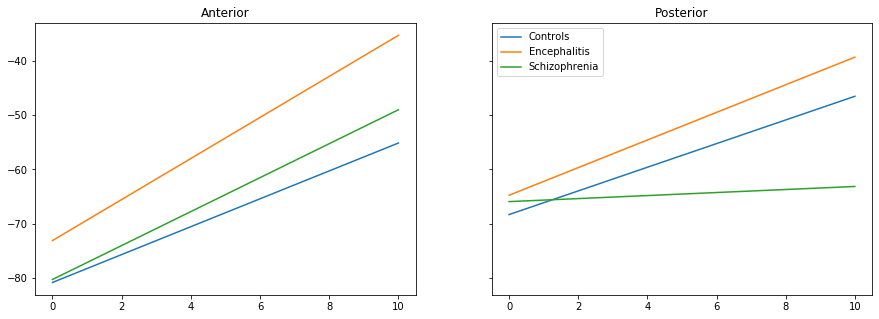

In [ ]:
# Plot
fig, ax = plt.subplots(1,2, figsize=(15,5), sharey=True)
X_plot = np.linspace(0,10,10)

# Anterior
ax[0].plot(X_plot, X_plot*mdl3f.params['WaveRes'] + mdl3f.params.Intercept, label = 'Controls', color = 'C0')
ax[0].plot(X_plot, X_plot*(mdl3f.params['WaveRes'] + mdl3f.params['WaveRes:Group[T.E]']) + mdl3f.params.Intercept + mdl3f.params['Group[T.E]'], label = 'Encephalitis', color = 'C1')
ax[0].plot(X_plot, X_plot*(mdl3f.params['WaveRes'] + mdl3f.params['WaveRes:Group[T.S]']) + mdl3f.params.Intercept + mdl3f.params['Group[T.S]'], label = 'Schizophrenia', color = 'C2')
ax[0].title.set_text('Anterior')
# Posterior
ax[1].plot(X_plot, X_plot*mdl4f.params['WaveRes'] + mdl4f.params.Intercept, label = 'Controls', color = 'C0')
ax[1].plot(X_plot, X_plot*(mdl4f.params['WaveRes'] + mdl4f.params['WaveRes:Group[T.E]']) + mdl4f.params.Intercept + mdl4f.params['Group[T.E]'], label = 'Encephalitis', color = 'C1')
ax[1].plot(X_plot, X_plot*(mdl4f.params['WaveRes'] + mdl4f.params['WaveRes:Group[T.S]']) + mdl4f.params.Intercept + mdl4f.params['Group[T.S]'], label = 'Schizophrenia', color = 'C2')
ax[1].title.set_text('Posterior')
plt.legend()

## Frontal - Controls & Encephalitis - session 1-4

In [ ]:
# Mixed model with random intercept
mdl7 = smf.mixedlm('ValNegPeak ~ WaveRes * Group * Session', dataCE_fp[dataCE_fp['Position']=='F'], groups = 'Subject')
mdl7f = mdl7.fit()
mdl7f.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Mixed Linear Model Regression Results
=========================================================================
Model:                  MixedLM     Dependent Variable:     ValNegPeak   
No. Observations:       1825000     Method:                 REML         
No. Groups:             44          Scale:                  915.3868     
Min. group size:        7324        Likelihood:             -8812396.6934
Max. group size:        206104      Converged:              Yes          
Mean group size:        41477.3                                          
-------------------------------------------------------------------------
                            Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
-------------------------------------------------------------------------
Intercept                  -84.397    1.977 -42.684 0.000 -88.272 -80.521
Group[T.E]                  10.211    2.861   3.568 0.000   4.602  15.819
WaveRes                      6.818    0.226  30.191 0.000   6.376   7.261
WaveRes:Group[T.E]           1.019    0.317   3.211 0.001   0.397   1.642
Session                      1.770    0.061  28.862 0.000   1.650   1.890
Group[T.E]:Session          -3.207    0.079 -40.509 0.000  -3.362  -3.051
WaveRes:Session             -1.421    0.098 -14.551 0.000  -1.612  -1.229
WaveRes:Group[T.E]:Session   1.825    0.129  14.129 0.000   1.572   2.078
Subject Var                 89.482    0.587                              
=========================================================================

"""

In [ ]:
# Mixed model with random intercept and random slope
mdl8 = smf.mixedlm('ValNegPeak ~ WaveRes * Group * Session', dataCE_fp[dataCE_fp['Position']=='F'], groups = 'Subject', re_formula = '~ WaveRes')
mdl8f = mdl8.fit()
mdl8f.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Mixed Linear Model Regression Results
==========================================================================
Model:                 MixedLM      Dependent Variable:      ValNegPeak   
No. Observations:      1825000      Method:                  REML         
No. Groups:            44           Scale:                   907.7965     
Min. group size:       7324         Likelihood:              -8804903.0815
Max. group size:       206104       Converged:               Yes          
Mean group size:       41477.3                                            
--------------------------------------------------------------------------
                            Coef.   Std.Err.    z    P>|z|  [0.025  0.975]
--------------------------------------------------------------------------
Intercept                   -82.454    2.842 -29.009 0.000 -88.025 -76.883
Group[T.E]                   10.732    4.113   2.609 0.009   2.670  18.794
WaveRes                       2.937    1.893   1.551 0.121  -0.774   6.647
WaveRes:Group[T.E]           -0.026    2.736  -0.010 0.992  -5.388   5.336
Session                       1.091    0.074  14.795 0.000   0.947   1.236
Group[T.E]:Session           -2.532    0.091 -27.833 0.000  -2.710  -2.354
WaveRes:Session              -0.064    0.128  -0.502 0.615  -0.314   0.186
WaveRes:Group[T.E]:Session    0.477    0.157   3.033 0.002   0.169   0.786
Subject Var                 185.245    1.445                              
Subject x WaveRes Cov      -102.446    0.902                              
WaveRes Var                  80.723    0.652                              
==========================================================================

"""

In [ ]:
# Mixed model with random intercept and random slope - Controls
cr10 = dataCE_fp['Position']=='F'
cr11 = dataCE_fp['Group'] == 'C'
mdl9 = smf.mixedlm('ValNegPeak ~ WaveRes * Session', dataCE_fp[cr10 & cr11], groups = 'Subject', re_formula = '~ WaveRes')
mdl9f = mdl9.fit()
mdl9f.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
               Mixed Linear Model Regression Results
====================================================================
Model:               MixedLM    Dependent Variable:    ValNegPeak   
No. Observations:    621134     Method:                REML         
No. Groups:          23         Scale:                 941.2714     
Min. group size:     7324       Likelihood:            -3008014.6745
Max. group size:     68507      Converged:             Yes          
Mean group size:     27005.8                                        
--------------------------------------------------------------------
                       Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
--------------------------------------------------------------------
Intercept             -82.461    2.425 -34.009 0.000 -87.213 -77.709
WaveRes                 2.949    1.582   1.864 0.062  -0.152   6.050
Session                 1.093    0.075  14.554 0.000   0.946   1.240
WaveRes:Session        -0.067    0.130  -0.519 0.604  -0.322   0.187
Subject Var           134.627    1.255                              
Subject x WaveRes Cov -61.581    0.725                              
WaveRes Var            55.813    0.561                              
====================================================================

"""

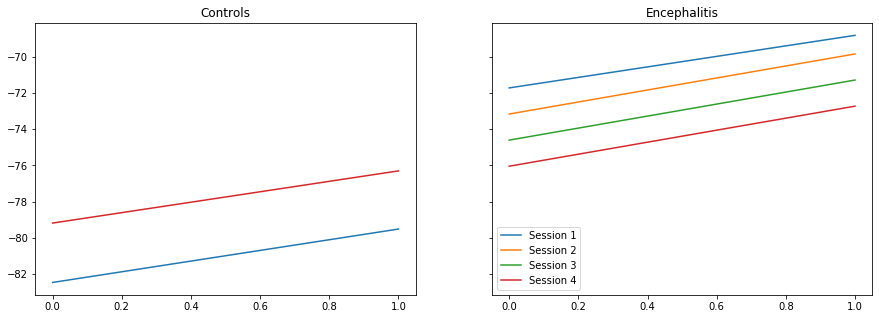

In [ ]:
# Plot controls vs encephalitis
fig, ax = plt.subplots(1,2, figsize=(15,5), sharey=True)
X_plot = np.linspace(0,1,10)
# Controls
ax[0].plot(X_plot, X_plot*mdl9f.params['WaveRes'] + mdl9f.params.Intercept, label = 'Session 1', color = 'C0')
ax[0].plot(X_plot, X_plot*(mdl9f.params['WaveRes'] + mdl9f.params['WaveRes:Session']) + mdl9f.params.Intercept + 3*mdl9f.params['Session'], label = 'Session 4', color = 'C3')
ax[0].title.set_text('Controls')
# Encephalitis
ax[1].plot(X_plot, X_plot*mdl10f.params['WaveRes'] + mdl10f.params.Intercept, label = 'Session 1', color = 'C0')
ax[1].plot(X_plot, X_plot*(mdl10f.params['WaveRes'] + mdl10f.params['WaveRes:Session']) + mdl10f.params.Intercept + mdl10f.params['Session'], label = 'Session 2', color = 'C1')
ax[1].plot(X_plot, X_plot*(mdl10f.params['WaveRes'] + mdl10f.params['WaveRes:Session']) + mdl10f.params.Intercept + 2*mdl10f.params['Session'], label = 'Session 3', color = 'C2')
ax[1].plot(X_plot, X_plot*(mdl10f.params['WaveRes'] + mdl10f.params['WaveRes:Session']) + mdl10f.params.Intercept + 3*mdl10f.params['Session'], label = 'Session 4', color = 'C3')
ax[1].title.set_text('Encephalitis')

plt.legend()

In [ ]:
# Encephalitis - Sessions - Frontal/Posterior
cr12 = dataCE_fp['Group'] == 'E'
mdl12 = smf.mixedlm('ValNegPeak ~ WaveRes * Session * Position', dataCE_fp[cr12], groups = 'Subject', re_formula = '~ WaveRes')
mdl12f = mdl12.fit()
mdl12f.summary()

/home/kanthida/anaconda3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2115: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                   Mixed Linear Model Regression Results
============================================================================
Model:                   MixedLM      Dependent Variable:      ValNegPeak   
No. Observations:        1863786      Method:                  REML         
No. Groups:              21           Scale:                   817.3375     
Min. group size:         11429        Likelihood:              -8894128.1152
Max. group size:         334678       Converged:               Yes          
Mean group size:         88751.7                                            
----------------------------------------------------------------------------
                               Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
----------------------------------------------------------------------------
Intercept                     -72.463    6.240 -11.613 0.000 -84.693 -60.233
Position[T.P]                   9.352    0.206  45.301 0.000   8.947   9.756
WaveRes                         3.795    6.243   0.608 0.543  -8.440  16.030
WaveRes:Position[T.P]          -3.796    0.357 -10.618 0.000  -4.496  -3.095
Session                        -1.476    0.049 -30.011 0.000  -1.573  -1.380
Session:Position[T.P]           1.052    0.078  13.547 0.000   0.900   1.204
WaveRes:Session                 0.613    0.085   7.200 0.000   0.446   0.780
WaveRes:Session:Position[T.P]  -0.747    0.135  -5.557 0.000  -1.011  -0.484
Subject Var                   817.337                                       
Subject x WaveRes Cov           0.000                                       
WaveRes Var                   817.337                                       
============================================================================

"""

In [ ]:
# Encephalitis - Sessions - Frontal
cr12 = dataCE_fp['Group'] == 'E'
mdl10 = smf.mixedlm('ValNegPeak ~ WaveRes * Session', dataCE_fp[cr10 & cr12], groups = 'Subject', re_formula = '~ WaveRes')
mdl10f = mdl10.fit()
mdl10f.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                Mixed Linear Model Regression Results
=====================================================================
Model:                MixedLM    Dependent Variable:    ValNegPeak   
No. Observations:     1203866    Method:                REML         
No. Groups:           21         Scale:                 890.5272     
Min. group size:      7650       Likelihood:            -5796570.4346
Max. group size:      206104     Converged:             Yes          
Mean group size:      57327.0                                        
---------------------------------------------------------------------
                       Coef.   Std.Err.    z    P>|z|  [0.025  0.975]
---------------------------------------------------------------------
Intercept              -71.719    3.311 -21.663 0.000 -78.207 -65.230
WaveRes                  2.903    2.285   1.271 0.204  -1.575   7.381
Session                 -1.441    0.053 -27.318 0.000  -1.545  -1.338
WaveRes:Session          0.414    0.091   4.532 0.000   0.235   0.593
Subject Var            229.774    2.752                              
Subject x WaveRes Cov -143.748    1.868                              
WaveRes Var            108.439    1.368                              
=====================================================================

"""

In [ ]:
# Encephalitis - Sessions - Posterior
cr13 = dataCE_fp['Position'] == 'P'
mdl11 = smf.mixedlm('ValNegPeak ~ WaveRes * Session', dataCE_fp[cr13 & cr12], groups = 'Subject', re_formula = '~ WaveRes')
mdl11f = mdl11.fit()
mdl11f.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
               Mixed Linear Model Regression Results
====================================================================
Model:               MixedLM    Dependent Variable:    ValNegPeak   
No. Observations:    659920     Method:                REML         
No. Groups:          21         Scale:                 670.0711     
Min. group size:     3779       Likelihood:            -3083682.5377
Max. group size:     128574     Converged:             Yes          
Mean group size:     31424.8                                        
--------------------------------------------------------------------
                       Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
--------------------------------------------------------------------
Intercept             -64.971    2.591 -25.080 0.000 -70.049 -59.894
WaveRes                 2.711    1.318   2.057 0.040   0.128   5.295
Session                -0.459    0.061  -7.545 0.000  -0.579  -0.340
WaveRes:Session         0.158    0.105   1.496 0.135  -0.049   0.364
Subject Var           140.340    1.880                              
Subject x WaveRes Cov -58.865    0.882                              
WaveRes Var            34.733    0.476                              
====================================================================

"""

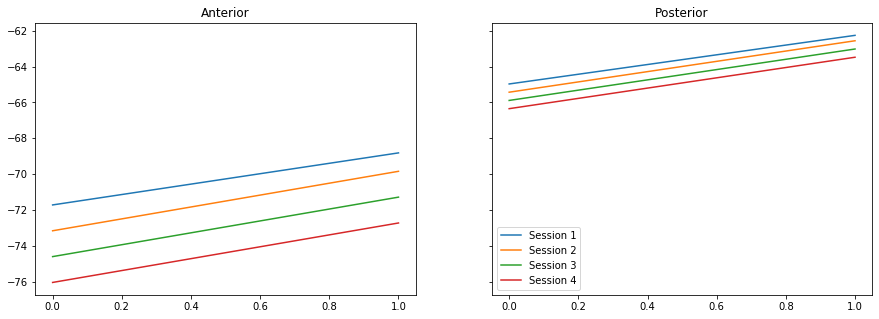

In [ ]:
# Plot encephalitis anterior-posterior
fig, ax = plt.subplots(1,2, figsize=(15,5), sharey=True)
X_plot = np.linspace(0,1,10)
# Anterior
ax[0].plot(X_plot, X_plot*mdl10f.params['WaveRes'] + mdl10f.params.Intercept, label = 'Session 1', color = 'C0')
ax[0].plot(X_plot, X_plot*(mdl10f.params['WaveRes'] + mdl10f.params['WaveRes:Session']) + mdl10f.params.Intercept + mdl10f.params['Session'], label = 'Session 2', color = 'C1')
ax[0].plot(X_plot, X_plot*(mdl10f.params['WaveRes'] + mdl10f.params['WaveRes:Session']) + mdl10f.params.Intercept + 2*mdl10f.params['Session'], label = 'Session 3', color = 'C2')
ax[0].plot(X_plot, X_plot*(mdl10f.params['WaveRes'] + mdl10f.params['WaveRes:Session']) + mdl10f.params.Intercept + 3*mdl10f.params['Session'], label = 'Session 4', color = 'C3')
ax[0].title.set_text('Anterior')
# Posterior
ax[1].plot(X_plot, X_plot*mdl11f.params['WaveRes'] + mdl11f.params.Intercept, label = 'Session 1', color = 'C0')
ax[1].plot(X_plot, X_plot*(mdl11f.params['WaveRes'] + mdl11f.params['WaveRes:Session']) + mdl11f.params.Intercept + mdl11f.params['Session'], label = 'Session 2', color = 'C1')
ax[1].plot(X_plot, X_plot*(mdl11f.params['WaveRes'] + mdl11f.params['WaveRes:Session']) + mdl11f.params.Intercept + 2*mdl11f.params['Session'], label = 'Session 3', color = 'C2')
ax[1].plot(X_plot, X_plot*(mdl11f.params['WaveRes'] + mdl11f.params['WaveRes:Session']) + mdl11f.params.Intercept + 3*mdl11f.params['Session'], label = 'Session 4', color = 'C3')
ax[1].title.set_text('Posterior')
plt.legend()

## Age and System

In [ ]:
data_fp1['age_demeaned'] = data_fp1['Age'] - np.mean(age.loc[age['Session']==1, 'Age'])

/home/kanthida/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
meanage1 = np.mean(age.loc[age['Session']==1, 'Age'])

In [ ]:
# A/P - all groups - session 1 - random intercept
md1 = smf.mixedlm('Slope ~ WaveRes * Group * Position * age_demeaned', data_fp1, groups = 'Subject')
md1f = md1.fit(reml=False)
md1f.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                             Mixed Linear Model Regression Results
================================================================================================
Model:                        MixedLM             Dependent Variable:             Slope         
No. Observations:             1971823             Method:                         ML            
No. Groups:                   63                  Scale:                          74179.6455    
Min. group size:              1899                Likelihood:                     -13854384.5621
Max. group size:              88966               Converged:                      Yes           
Mean group size:              31298.8                                                           
------------------------------------------------------------------------------------------------
                                               Coef.   Std.Err.    z     P>|z|  [0.025   0.975] 
------------------------------------------------------------------------------------------------
Intercept                                      680.279   15.776   43.122 0.000  649.359  711.198
Group[T.E]                                     -57.475   22.942   -2.505 0.012 -102.441  -12.509
Group[T.S]                                     -29.965   23.234   -1.290 0.197  -75.504   15.573
Position[T.P]                                 -210.719    1.458 -144.489 0.000 -213.578 -207.861
Group[T.E]:Position[T.P]                        34.481    2.158   15.982 0.000   30.252   38.709
Group[T.S]:Position[T.P]                        48.544    2.640   18.386 0.000   43.369   53.719
WaveRes                                       -151.490    1.482 -102.207 0.000 -154.395 -148.585
WaveRes:Group[T.E]                               7.203    2.163    3.329 0.001    2.962   11.443
WaveRes:Group[T.S]                              53.336    2.535   21.037 0.000   48.367   58.305
WaveRes:Position[T.P]                           89.543    2.519   35.544 0.000   84.606   94.481
WaveRes:Group[T.E]:Position[T.P]                 2.885    3.728    0.774 0.439   -4.422   10.191
WaveRes:Group[T.S]:Position[T.P]                 5.184    4.553    1.139 0.255   -3.740   14.109
age_demeaned                                   -10.872    1.712   -6.349 0.000  -14.228   -7.515
Group[T.E]:age_demeaned                          1.840    2.279    0.807 0.420   -2.628    6.307
Group[T.S]:age_demeaned                          1.989    2.595    0.766 0.443   -3.097    7.074
Position[T.P]:age_demeaned                       3.969    0.165   24.063 0.000    3.646    4.292
Group[T.E]:Position[T.P]:age_demeaned           -3.212    0.235  -13.685 0.000   -3.672   -2.752
Group[T.S]:Position[T.P]:age_demeaned           -0.556    0.340   -1.632 0.103   -1.223    0.112
WaveRes:age_demeaned                             5.964    0.177   33.638 0.000    5.616    6.311
WaveRes:Group[T.E]:age_demeaned                 -0.052    0.238   -0.220 0.826   -0.520    0.415
WaveRes:Group[T.S]:age_demeaned                  0.690    0.333    2.075 0.038    0.038    1.342
WaveRes:Position[T.P]:age_demeaned              -3.417    0.285  -11.990 0.000   -3.976   -2.858
WaveRes:Group[T.E]:Position[T.P]:age_demeaned    2.444    0.405    6.032 0.000    1.650    3.239
WaveRes:Group[T.S]:Position[T.P]:age_demeaned    2.795    0.587    4.765 0.000    1.645    3.945
Subject Var                                   5425.349    3.584                                 
================================================================================================

"""

In [ ]:
# A/P - all groups - session 1 - random intercept and random slope
md2 = smf.mixedlm('Slope ~ WaveRes * Group * Position * age_demeaned', data_fp1, groups = 'Subject', re_formula = '~ WaveRes')
md2f = md2.fit(reml=False)
md2f.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                              Mixed Linear Model Regression Results
=================================================================================================
Model:                         MixedLM             Dependent Variable:             Slope         
No. Observations:              1971823             Method:                         ML            
No. Groups:                    63                  Scale:                          73864.7061    
Min. group size:               1899                Likelihood:                     -13850325.6277
Max. group size:               88966               Converged:                      Yes           
Mean group size:               31298.8                                                           
-------------------------------------------------------------------------------------------------
                                                Coef.   Std.Err.    z     P>|z|  [0.025   0.975] 
-------------------------------------------------------------------------------------------------
Intercept                                       670.774   18.947   35.402 0.000  633.638  707.910
Group[T.E]                                      -60.753   27.559   -2.204 0.027 -114.768   -6.738
Group[T.S]                                      -21.524   27.908   -0.771 0.441  -76.222   33.174
Position[T.P]                                  -211.222    1.466 -144.108 0.000 -214.095 -208.349
Group[T.E]:Position[T.P]                         35.167    2.166   16.232 0.000   30.921   39.413
Group[T.S]:Position[T.P]                         47.741    2.663   17.928 0.000   42.522   52.960
WaveRes                                        -132.484   13.011  -10.183 0.000 -157.984 -106.983
WaveRes:Group[T.E]                               13.735   18.953    0.725 0.469  -23.411   50.881
WaveRes:Group[T.S]                               36.453   19.239    1.895 0.058   -1.255   74.161
WaveRes:Position[T.P]                            90.551    2.538   35.678 0.000   85.577   95.526
WaveRes:Group[T.E]:Position[T.P]                  1.511    3.751    0.403 0.687   -5.842    8.863
WaveRes:Group[T.S]:Position[T.P]                  6.792    4.609    1.474 0.141   -2.241   15.825
age_demeaned                                    -10.708    2.056   -5.207 0.000  -14.738   -6.677
Group[T.E]:age_demeaned                           2.558    2.737    0.935 0.350   -2.807    7.923
Group[T.S]:age_demeaned                           2.550    3.118    0.818 0.413   -3.561    8.661
Position[T.P]:age_demeaned                        3.904    0.166   23.564 0.000    3.579    4.229
Group[T.E]:Position[T.P]:age_demeaned            -2.600    0.236  -11.012 0.000   -3.063   -2.137
Group[T.S]:Position[T.P]:age_demeaned            -0.264    0.344   -0.767 0.443   -0.937    0.410
WaveRes:age_demeaned                              5.635    1.413    3.987 0.000    2.865    8.406
WaveRes:Group[T.E]:age_demeaned                  -1.487    1.883   -0.790 0.430   -5.178    2.203
WaveRes:Group[T.S]:age_demeaned                  -0.432    2.169   -0.199 0.842   -4.683    3.819
WaveRes:Position[T.P]:age_demeaned               -3.287    0.287  -11.459 0.000   -3.849   -2.725
WaveRes:Group[T.E]:Position[T.P]:age_demeaned     1.221    0.409    2.988 0.003    0.420    2.022
WaveRes:Group[T.S]:Position[T.P]:age_demeaned     2.212    0.595    3.721 0.000    1.047    3.378
Subject Var                                    7831.313    4.752                                 
Subject x WaveRes Cov                         -3766.278    2.879                                 
WaveRes Var                                    3644.813    2.359                                 
=================================================================================================

"""

In [ ]:
# A/P - all groups - session 1 - random intercept
md3 = smf.mixedlm('Slope ~ WaveRes * Group * Position * age_demeaned + WaveRes * Machine', data_fp1, groups = 'Subject')
md3f = md3.fit(reml=False)
md3f.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                             Mixed Linear Model Regression Results
================================================================================================
Model:                        MixedLM             Dependent Variable:             Slope         
No. Observations:             1971823             Method:                         ML            
No. Groups:                   63                  Scale:                          74179.1968    
Min. group size:              1899                Likelihood:                     -13854378.4085
Max. group size:              88966               Converged:                      Yes           
Mean group size:              31298.8                                                           
------------------------------------------------------------------------------------------------
                                               Coef.   Std.Err.    z     P>|z|  [0.025   0.975] 
------------------------------------------------------------------------------------------------
Intercept                                      690.537   25.024   27.595 0.000  641.492  739.582
Group[T.E]                                     -58.473   22.954   -2.547 0.011 -103.461  -13.485
Group[T.S]                                     -33.568   24.095   -1.393 0.164  -80.794   13.657
Position[T.P]                                 -210.597    1.459 -144.362 0.000 -213.456 -207.737
Machine[T.O]                                   -11.954   22.805   -0.524 0.600  -56.651   32.743
Group[T.E]:Position[T.P]                        34.317    2.158   15.902 0.000   30.087   38.547
Group[T.S]:Position[T.P]                        48.523    2.640   18.378 0.000   43.348   53.698
WaveRes                                       -146.882    1.996  -73.597 0.000 -150.793 -142.970
WaveRes:Group[T.E]                               6.718    2.168    3.099 0.002    2.469   10.967
WaveRes:Group[T.S]                              51.977    2.566   20.258 0.000   46.948   57.006
WaveRes:Position[T.P]                           89.297    2.520   35.433 0.000   84.358   94.237
WaveRes:Machine[T.O]                            -5.530    1.604   -3.448 0.001   -8.673   -2.386
WaveRes:Group[T.E]:Position[T.P]                 3.213    3.729    0.862 0.389   -4.096   10.522
WaveRes:Group[T.S]:Position[T.P]                 5.227    4.553    1.148 0.251   -3.698   14.151
age_demeaned                                   -11.043    1.738   -6.356 0.000  -14.449   -7.638
Group[T.E]:age_demeaned                          1.976    2.288    0.864 0.388   -2.507    6.460
Group[T.S]:age_demeaned                          1.932    2.588    0.746 0.455   -3.140    7.004
Position[T.P]:age_demeaned                       3.977    0.165   24.110 0.000    3.654    4.300
Group[T.E]:Position[T.P]:age_demeaned           -3.230    0.235  -13.761 0.000   -3.691   -2.770
Group[T.S]:Position[T.P]:age_demeaned           -0.536    0.340   -1.574 0.116   -1.203    0.131
WaveRes:age_demeaned                             5.889    0.179   32.976 0.000    5.539    6.239
WaveRes:Group[T.E]:age_demeaned                  0.014    0.239    0.057 0.955   -0.455    0.482
WaveRes:Group[T.S]:age_demeaned                  0.717    0.333    2.156 0.031    0.065    1.369
WaveRes:Position[T.P]:age_demeaned              -3.434    0.285  -12.047 0.000   -3.992   -2.875
WaveRes:Group[T.E]:Position[T.P]:age_demeaned    2.482    0.405    6.123 0.000    1.687    3.277
WaveRes:Group[T.S]:Position[T.P]:age_demeaned    2.755    0.587    4.696 0.000    1.605    3.906
Subject Var                                   5392.599    3.565                                 
================================================================================================

"""

In [ ]:
# A/P - all groups - session 1 - random intercept and random slope
md4 = smf.mixedlm('Slope ~ WaveRes * Group * Position * age_demeaned + WaveRes * Machine', data_fp1, groups = 'Subject', re_formula = '~ WaveRes')
md4f = md4.fit(reml=False)
md4f.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                              Mixed Linear Model Regression Results
=================================================================================================
Model:                         MixedLM             Dependent Variable:             Slope         
No. Observations:              1971823             Method:                         ML            
No. Groups:                    63                  Scale:                          73864.7023    
Min. group size:               1899                Likelihood:                     -13850325.1396
Max. group size:               88966               Converged:                      Yes           
Mean group size:               31298.8                                                           
-------------------------------------------------------------------------------------------------
                                                Coef.   Std.Err.    z     P>|z|  [0.025   0.975] 
-------------------------------------------------------------------------------------------------
Intercept                                       691.117   30.024   23.019 0.000  632.272  749.962
Group[T.E]                                      -62.768   27.541   -2.279 0.023 -116.748   -8.788
Group[T.S]                                      -28.450   28.908   -0.984 0.325  -85.107   28.208
Position[T.P]                                  -211.225    1.466 -144.110 0.000 -214.098 -208.352
Machine[T.O]                                    -23.838   27.365   -0.871 0.384  -77.473   29.797
Group[T.E]:Position[T.P]                         35.170    2.166   16.234 0.000   30.924   39.416
Group[T.S]:Position[T.P]                         47.740    2.663   17.928 0.000   42.521   52.959
WaveRes                                        -148.032   20.526   -7.212 0.000 -188.262 -107.801
WaveRes:Group[T.E]                               15.286   18.887    0.809 0.418  -21.732   52.304
WaveRes:Group[T.S]                               41.733   19.854    2.102 0.036    2.819   80.647
WaveRes:Position[T.P]                            90.557    2.538   35.681 0.000   85.582   95.531
WaveRes:Machine[T.O]                             18.221   18.700    0.974 0.330  -18.430   54.873
WaveRes:Group[T.E]:Position[T.P]                  1.506    3.751    0.401 0.688   -5.847    8.858
WaveRes:Group[T.S]:Position[T.P]                  6.794    4.609    1.474 0.140   -2.239   15.827
age_demeaned                                    -11.045    2.084   -5.300 0.000  -15.130   -6.960
Group[T.E]:age_demeaned                           2.833    2.744    1.032 0.302   -2.546    8.211
Group[T.S]:age_demeaned                           2.482    3.106    0.799 0.424   -3.606    8.570
Position[T.P]:age_demeaned                        3.904    0.166   23.563 0.000    3.579    4.228
Group[T.E]:Position[T.P]:age_demeaned            -2.599    0.236  -11.010 0.000   -3.062   -2.137
Group[T.S]:Position[T.P]:age_demeaned            -0.264    0.344   -0.769 0.442   -0.938    0.409
WaveRes:age_demeaned                              5.894    1.428    4.126 0.000    3.094    8.693
WaveRes:Group[T.E]:age_demeaned                  -1.697    1.882   -0.902 0.367   -5.386    1.991
WaveRes:Group[T.S]:age_demeaned                  -0.382    2.155   -0.177 0.859   -4.605    3.840
WaveRes:Position[T.P]:age_demeaned               -3.287    0.287  -11.457 0.000   -3.849   -2.724
WaveRes:Group[T.E]:Position[T.P]:age_demeaned     1.221    0.409    2.986 0.003    0.419    2.022
WaveRes:Group[T.S]:Position[T.P]:age_demeaned     2.213    0.595    3.722 0.000    1.048    3.379
Subject Var                                    7765.890    4.723                                 
Subject x WaveRes Cov                         -3706.896    2.844                                 
WaveRes Var                                    3592.547    2.323                                 
=============================================================

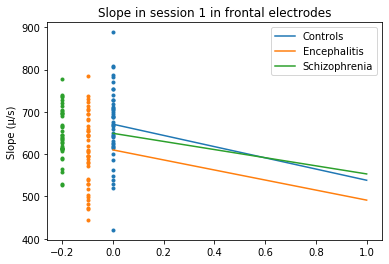

In [ ]:
# plot mixed model with random intercept

d = md2f.random_effects
dlist = []
for i in d: 
    dlist.append(d[i])

plt.plot(np.zeros(len(dlist[:22])), dlist[:22] + md2f.params.Intercept, marker = '.', linestyle='', color = 'C0' )
plt.plot(np.zeros(len(dlist[22:43]))-.1, dlist[22:43] + md2f.params.Intercept + md2f.params['Group[T.E]'], marker = '.', linestyle='', color = 'C1')
plt.plot(np.zeros(len(dlist[43:]))-.2, dlist[43:] + md2f.params.Intercept + md2f.params['Group[T.S]'], marker = '.', linestyle='', color = 'C2')

X_plot = np.linspace(0,1,10)
plt.plot(X_plot, X_plot*md2f.params['WaveRes'] + md2f.params.Intercept, label = 'Controls', color = 'C0')
plt.plot(X_plot, X_plot*(md2f.params['WaveRes']+md2f.params['WaveRes:Group[T.E]']) + md2f.params.Intercept + md2f.params['Group[T.E]'], label = 'Encephalitis', color = 'C1')
plt.plot(X_plot, X_plot*(md2f.params['WaveRes']+md2f.params['WaveRes:Group[T.S]']) + md2f.params.Intercept + md2f.params['Group[T.S]'], label = 'Schizophrenia', color = 'C2')
plt.legend()
plt.title('Slope in session 1 in frontal electrodes')
plt.ylabel('Slope (μ/s)')
plt.show()

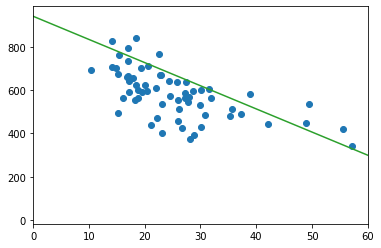

In [ ]:
# age and slope
meanslopesubj = data_fp1[data_fp1['Position']=='F'].groupby(['Subject','Age'], as_index = False)['Slope'].mean()

plt.scatter(meanslopesubj['Age'], meanslopesubj['Slope'])
X_plot = np.linspace(-meanage1,60,100)
plt.plot(X_plot+meanage1, (X_plot)*md2f.params['age_demeaned'] + md2f.params.Intercept, color = 'C02')
plt.xlim(0, 60)

plt.savefig('age.png')
plt.show()

In [ ]:
print(md1f.aic)
print(md2f.aic)
print(md3f.aic)
print(md4f.aic)

27708821.124107596
27700707.255447853
27708812.816935506
27700710.279257316


In [ ]:
# Anterior - all groups - session 1 - random intercept and random slope
md5 = smf.mixedlm('Slope ~ WaveRes * Group * age_demeaned', data_fp1[data_fp1['Position']=='F'], groups = 'Subject', re_formula = '~ WaveRes')
md5f = md5.fit(reml=False)
md5f.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                     Mixed Linear Model Regression Results
================================================================================
Model:                   MixedLM        Dependent Variable:        Slope        
No. Observations:        1277083        Method:                    ML           
No. Groups:              63             Scale:                     83547.4472   
Min. group size:         1400           Likelihood:                -9049160.3158
Max. group size:         53048          Converged:                 Yes          
Mean group size:         20271.2                                                
--------------------------------------------------------------------------------
                                  Coef.   Std.Err.   z    P>|z|  [0.025   0.975]
--------------------------------------------------------------------------------
Intercept                         664.743   23.625 28.138 0.000  618.440 711.047
Group[T.E]                        -62.577   34.362 -1.821 0.069 -129.925   4.772
Group[T.S]                        -15.438   34.793 -0.444 0.657  -83.632  52.755
WaveRes                          -128.250   16.211 -7.912 0.000 -160.023 -96.478
WaveRes:Group[T.E]                 16.994   23.612  0.720 0.472  -29.285  63.274
WaveRes:Group[T.S]                 34.038   23.956  1.421 0.155  -12.915  80.991
age_demeaned                      -10.651    2.564 -4.154 0.000  -15.676  -5.625
Group[T.E]:age_demeaned             2.331    3.413  0.683 0.495   -4.358   9.020
Group[T.S]:age_demeaned             2.709    3.887  0.697 0.486   -4.909  10.328
WaveRes:age_demeaned                5.695    1.760  3.235 0.001    2.245   9.145
WaveRes:Group[T.E]:age_demeaned    -1.508    2.345 -0.643 0.520   -6.104   3.087
WaveRes:Group[T.S]:age_demeaned    -0.666    2.698 -0.247 0.805   -5.955   4.622
Subject Var                     12181.247    7.791                              
Subject x WaveRes Cov           -6460.352    4.875                              
WaveRes Var                      5677.006    3.770                              
================================================================================

"""

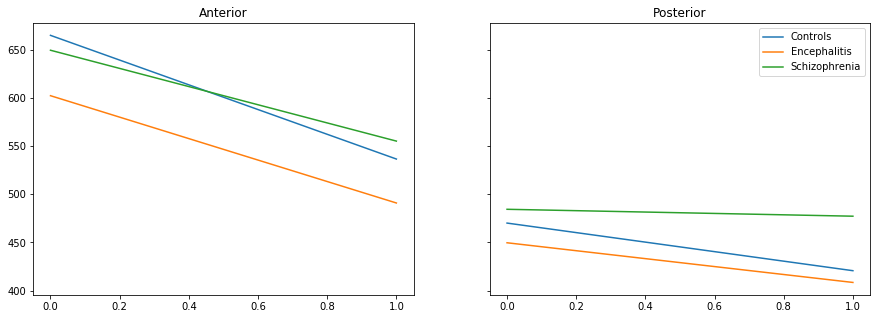

In [ ]:
# Plot anterior-posterior
fig, ax = plt.subplots(1,2, figsize=(15,5), sharey=True)
X_plot = np.linspace(0,1,10)

# Anterior
ax[0].plot(X_plot, X_plot*md5f.params['WaveRes'] + md5f.params.Intercept, label = 'Controls', color = 'C0')
ax[0].plot(X_plot, X_plot*(md5f.params['WaveRes'] + md5f.params['WaveRes:Group[T.E]']) + md5f.params.Intercept + md5f.params['Group[T.E]'], label = 'Encephalitis', color = 'C1')
ax[0].plot(X_plot, X_plot*(md5f.params['WaveRes'] + md5f.params['WaveRes:Group[T.S]']) + md5f.params.Intercept + md5f.params['Group[T.S]'], label = 'Schizophrenia', color = 'C2')
ax[0].title.set_text('Anterior')
# Posterior
ax[1].plot(X_plot, X_plot*md6f.params['WaveRes'] + md6f.params.Intercept, label = 'Controls', color = 'C0')
ax[1].plot(X_plot, X_plot*(md6f.params['WaveRes'] + md6f.params['WaveRes:Group[T.E]']) + md6f.params.Intercept + md6f.params['Group[T.E]'], label = 'Encephalitis', color = 'C1')
ax[1].plot(X_plot, X_plot*(md6f.params['WaveRes'] + md6f.params['WaveRes:Group[T.S]']) + md6f.params.Intercept + md6f.params['Group[T.S]'], label = 'Schizophrenia', color = 'C2')
ax[1].title.set_text('Posterior')
plt.legend()

In [ ]:
# Posterior - all groups - session 1 - random intercept
md6 = smf.mixedlm('Slope ~ WaveRes * Group * age_demeaned', data_fp1[data_fp1['Position']=='P'], groups = 'Subject', re_formula = '~ WaveRes')
md6f = md6.fit(reml=False)
md6f.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                     Mixed Linear Model Regression Results
===============================================================================
Model:                    MixedLM       Dependent Variable:       Slope        
No. Observations:         694740        Method:                   ML           
No. Groups:               63            Scale:                    54256.7513   
Min. group size:          499           Likelihood:               -4772948.8044
Max. group size:          37178         Converged:                Yes          
Mean group size:          11027.6                                              
-------------------------------------------------------------------------------
                                  Coef.   Std.Err.   z    P>|z|  [0.025  0.975]
-------------------------------------------------------------------------------
Intercept                         470.071   15.026 31.284 0.000 440.621 499.521
Group[T.E]                        -20.418   21.876 -0.933 0.351 -63.295  22.458
Group[T.S]                         14.301   22.198  0.644 0.519 -29.206  57.809
WaveRes                           -49.378   11.340 -4.354 0.000 -71.605 -27.151
WaveRes:Group[T.E]                  8.233   16.588  0.496 0.620 -24.279  40.744
WaveRes:Group[T.S]                 42.214   17.009  2.482 0.013   8.877  75.551
age_demeaned                       -6.934    1.630 -4.254 0.000 -10.129  -3.739
Group[T.E]:age_demeaned             0.701    2.173  0.322 0.747  -3.559   4.960
Group[T.S]:age_demeaned             2.215    2.491  0.889 0.374  -2.667   7.098
WaveRes:age_demeaned                2.125    1.229  1.730 0.084  -0.283   4.534
WaveRes:Group[T.E]:age_demeaned    -0.065    1.649 -0.039 0.969  -3.297   3.168
WaveRes:Group[T.S]:age_demeaned     1.911    1.954  0.978 0.328  -1.918   5.741
Subject Var                      4907.005    3.900                             
Subject x WaveRes Cov           -1973.084    2.362                             
WaveRes Var                      2722.361    2.184                             
===============================================================================

"""

In [ ]:
# A - C/E - sessions 1-4 - random intercept
meanageCE14 = np.mean(age.loc[((age['Session'] != 5)&(age['Group'] != 3)),'Age'])
dataCE_fp['age_demeaned'] = dataCE_fp['Age'] - meanageCE14

/home/kanthida/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
md7 = smf.mixedlm('Slope ~ WaveRes * Group * Session * age_demeaned + WaveRes * Machine', dataCE_fp[dataCE_fp['Position']=='F'], groups = 'Subject')
md7f = md7.fit(reml=False)
md7f.summary()

/home/kanthida/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Mixed Linear Model Regression Results
=========================================================================================
Model:                       MixedLM          Dependent Variable:          Slope         
No. Observations:            1825000          Method:                      ML            
No. Groups:                  44               Scale:                       83648.0928    
Min. group size:             7324             Likelihood:                  -12932352.4687
Max. group size:             206104           Converged:                   Yes           
Mean group size:             41477.3                                                     
-----------------------------------------------------------------------------------------
                                         Coef.   Std.Err.    z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------------------------------
Intercept                                705.109   18.343  38.440 0.000  669.158  741.061
Group[T.E]                               -87.754   25.972  -3.379 0.001 -138.658  -36.849
Machine[T.O]                             -33.730    1.522 -22.165 0.000  -36.713  -30.747
WaveRes                                 -151.769    2.958 -51.305 0.000 -157.567 -145.971
WaveRes:Group[T.E]                        41.859    3.292  12.716 0.000   35.407   48.311
WaveRes:Machine[T.O]                      -8.882    1.893  -4.692 0.000  -12.593   -5.172
Session                                  -14.492    0.987 -14.688 0.000  -16.426  -12.558
Group[T.E]:Session                        25.164    1.200  20.965 0.000   22.812   27.517
WaveRes:Session                           16.724    1.113  15.028 0.000   14.543   18.905
WaveRes:Group[T.E]:Session               -28.307    1.383 -20.461 0.000  -31.018  -25.595
age_demeaned                             -12.436    1.946  -6.389 0.000  -16.251   -8.622
Group[T.E]:age_demeaned                    4.421    2.500   1.769 0.077   -0.478    9.319
WaveRes:age_demeaned                       6.668    0.291  22.923 0.000    6.098    7.238
WaveRes:Group[T.E]:age_demeaned           -0.981    0.367  -2.670 0.008   -1.701   -0.261
Session:age_demeaned                       1.557    0.100  15.520 0.000    1.360    1.753
Group[T.E]:Session:age_demeaned           -1.827    0.111 -16.417 0.000   -2.045   -1.609
WaveRes:Session:age_demeaned              -0.824    0.159  -5.186 0.000   -1.135   -0.512
WaveRes:Group[T.E]:Session:age_demeaned    0.875    0.180   4.870 0.000    0.523    1.227
Subject Var                             7049.125    4.866                                
=========================================================================================

"""

In [ ]:
# A - C/E - sessions 1-4 - random intercept and random slope
md8 = smf.mixedlm('Slope ~ WaveRes * Group * Session * age_demeaned + WaveRes * Machine', dataCE_fp[dataCE_fp['Position']=='F'], groups = 'Subject', re_formula = '~ WaveRes')
md8f = md8.fit(reml=False)
md8f.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Mixed Linear Model Regression Results
==========================================================================================
Model:                      MixedLM           Dependent Variable:           Slope         
No. Observations:           1825000           Method:                       ML            
No. Groups:                 44                Scale:                        83181.4669    
Min. group size:            7324              Likelihood:                   -12927344.8529
Max. group size:            206104            Converged:                    Yes           
Mean group size:            41477.3                                                       
------------------------------------------------------------------------------------------
                                          Coef.   Std.Err.    z    P>|z|  [0.025   0.975] 
------------------------------------------------------------------------------------------
Intercept                                 698.804   27.165  25.725 0.000  645.562  752.046
Group[T.E]                                -78.419   38.449  -2.040 0.041 -153.777   -3.060
Machine[T.O]                              -50.451    2.311 -21.827 0.000  -54.981  -45.920
WaveRes                                  -139.323   17.153  -8.122 0.000 -172.942 -105.704
WaveRes:Group[T.E]                         23.272   23.659   0.984 0.325  -23.099   69.643
WaveRes:Machine[T.O]                       24.543    3.909   6.279 0.000   16.881   32.205
Session                                    -5.830    1.352  -4.312 0.000   -8.480   -3.180
Group[T.E]:Session                         13.969    1.596   8.754 0.000   10.841   17.097
WaveRes:Session                            -0.558    1.698  -0.329 0.742   -3.887    2.770
WaveRes:Group[T.E]:Session                 -5.990    1.908  -3.139 0.002   -9.730   -2.250
age_demeaned                              -12.962    2.875  -4.508 0.000  -18.598   -7.327
Group[T.E]:age_demeaned                     6.513    3.669   1.775 0.076   -0.679   13.704
WaveRes:age_demeaned                        7.672    1.779   4.312 0.000    4.185   11.159
WaveRes:Group[T.E]:age_demeaned            -5.023    2.299  -2.185 0.029   -9.529   -0.516
Session:age_demeaned                        2.128    0.122  17.503 0.000    1.890    2.367
Group[T.E]:Session:age_demeaned            -2.683    0.131 -20.536 0.000   -2.939   -2.427
WaveRes:Session:age_demeaned               -1.964    0.210  -9.361 0.000   -2.376   -1.553
WaveRes:Group[T.E]:Session:age_demeaned     2.584    0.226  11.447 0.000    2.141    3.026
Subject Var                             15491.740   13.221                                
Subject x WaveRes Cov                   -8426.922    7.688                                
WaveRes Var                              5736.312    4.908                                
==========================================================================================

"""

In [ ]:
print(md7f.aic)
print(md8f.aic)

25864744.93731795
25854733.70585755


In [ ]:
# A/P - C - sessions 1-4 - random intercept and random slope
md9 = smf.mixedlm('Slope ~ WaveRes * Session * age_demeaned + WaveRes * Machine', dataCE_fp[(dataCE_fp['Group'] == 'C')&(dataCE_fp['Position']=='F')], groups = 'Subject', re_formula = '~ WaveRes')
md9f = md9.fit(reml=False)
md9f.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                    Mixed Linear Model Regression Results
==============================================================================
Model:                   MixedLM       Dependent Variable:       Slope        
No. Observations:        621134        Method:                   ML           
No. Groups:              23            Scale:                    87682.1260   
Min. group size:         7324          Likelihood:               -4416195.2695
Max. group size:         68507         Converged:                Yes          
Mean group size:         27005.8                                              
------------------------------------------------------------------------------
                               Coef.   Std.Err.    z    P>|z|  [0.025   0.975]
------------------------------------------------------------------------------
Intercept                      647.292   26.430  24.490 0.000  595.489 699.095
Machine[T.O]                     5.190    4.901   1.059 0.290   -4.417  14.796
WaveRes                        -62.613   19.793  -3.163 0.002 -101.407 -23.819
WaveRes:Machine[T.O]           -54.469    8.368  -6.509 0.000  -70.870 -38.067
Session                          1.729    1.481   1.167 0.243   -1.174   4.631
WaveRes:Session                -11.735    2.059  -5.698 0.000  -15.772  -7.699
age_demeaned                   -10.959    2.869  -3.819 0.000  -16.583  -5.336
WaveRes:age_demeaned             6.196    1.976   3.135 0.002    2.322  10.069
Session:age_demeaned             2.666    0.132  20.229 0.000    2.408   2.924
WaveRes:Session:age_demeaned    -2.727    0.228 -11.984 0.000   -3.173  -2.281
Subject Var                  14243.494   15.057                               
Subject x WaveRes Cov        -8746.981    9.880                               
WaveRes Var                   6634.783    7.171                               
==============================================================================

"""

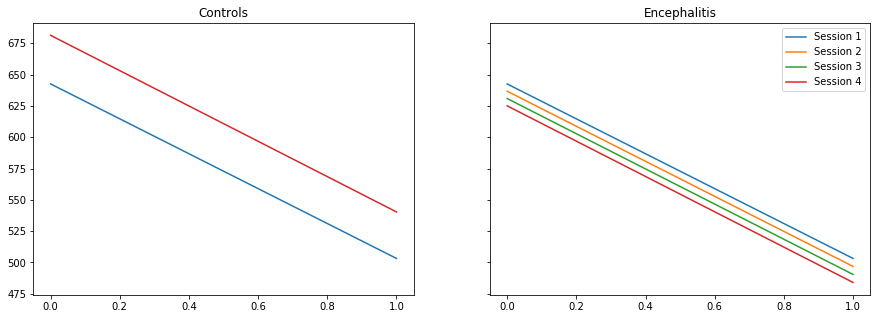

In [ ]:
# Plot controls vs encephalitis
fig, ax = plt.subplots(1,2, figsize=(15,5), sharey=True)
X_plot = np.linspace(0,1,10)
# Controls
ax[0].plot(X_plot, X_plot*md8f.params['WaveRes'] + md8f.params.Intercept + md8f.params['Machine[T.O]'] + md8f.params['Session'], label = 'Session 1', color = 'C0')
ax[0].plot(X_plot, X_plot*(md8f.params['WaveRes'] + 3*md8f.params['WaveRes:Session']) + md8f.params.Intercept + 3*md8f.params['Session'], label = 'Session 4', color = 'C3')
ax[0].title.set_text('Controls')
# Encephalitis
ax[1].plot(X_plot, X_plot*md8f.params['WaveRes'] + md8f.params.Intercept + md8f.params['Machine[T.O]'] + md8f.params['Session'], label = 'Session 1', color = 'C0')
ax[1].plot(X_plot, X_plot*(md8f.params['WaveRes'] + md8f.params['WaveRes:Session']) + md8f.params.Intercept + md8f.params['Session'] + md8f.params['Machine[T.O]'] + md8f.params['Session'], label = 'Session 2', color = 'C1')
ax[1].plot(X_plot, X_plot*(md8f.params['WaveRes'] + 2*md8f.params['WaveRes:Session']) + md8f.params.Intercept + 2*md8f.params['Session'] + md8f.params['Machine[T.O]'] + md8f.params['Session'], label = 'Session 3', color = 'C2')
ax[1].plot(X_plot, X_plot*(md8f.params['WaveRes'] + 3*md8f.params['WaveRes:Session']) + md8f.params.Intercept + 3*md8f.params['Session'] + md8f.params['Machine[T.O]'] + md8f.params['Session'], label = 'Session 4', color = 'C3')
ax[1].title.set_text('Encephalitis')

plt.legend()

In [ ]:
# A/P - E - sessions 1-4 - random intercept and random slope
md13 = smf.mixedlm('Slope ~ WaveRes * Session + WaveRes * age_demeaned + WaveRes * Machine ', dataCE_fp[dataCE_fp['Group'] == 'E'], groups = 'Subject', re_formula = '~ WaveRes')
md13f = md13.fit(reml=False)
md13f.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Mixed Linear Model Regression Results
=========================================================================
Model:                 MixedLM     Dependent Variable:     Slope         
No. Observations:      1863786     Method:                 ML            
No. Groups:            21          Scale:                  77010.3144    
Min. group size:       11429       Likelihood:             -13130139.7444
Max. group size:       334678      Converged:              Yes           
Mean group size:       88751.7                                           
-------------------------------------------------------------------------
                         Coef.    Std.Err.    z    P>|z|  [0.025   0.975]
-------------------------------------------------------------------------
Intercept                 616.206   94.875   6.495 0.000  430.254 802.157
Machine[T.O]              -46.057    1.943 -23.709 0.000  -49.864 -42.249
WaveRes                  -117.988   51.099  -2.309 0.021 -218.140 -17.837
WaveRes:Machine[T.O]       25.199    3.031   8.313 0.000   19.258  31.139
Session                    21.437    1.556  13.779 0.000   18.388  24.486
WaveRes:Session           -13.468    1.412  -9.538 0.000  -16.236 -10.701
age_demeaned              -54.948    5.100 -10.775 0.000  -64.944 -44.953
WaveRes:age_demeaned       29.017    4.035   7.191 0.000   21.108  36.926
Subject Var            188279.516  190.218                               
Subject x WaveRes Cov -100309.128  111.222                               
WaveRes Var             54192.043   68.210                               
=========================================================================

"""

# Confusional Arousals

In [ ]:
cfsubj = ['E02','E03','E05','E06','E07','E16','E21','E22','C11','C12','C14','C18']
dataCE_fp['ConfArousal'] = 0
dataCE_fp.loc[dataCE_fp.Subject.isin(cfsubj),'ConfArousal'] = 1
dataCE_fp.loc[:,'ConfArousal'] = dataCE_fp.loc[:,'ConfArousal'].astype('category')
dataCE_fp

/home/kanthida/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Wave,Start,NegPeak,MidCrossing,PosPeak,End,Duration,ValNegPeak,ValPosPeak,PTP,...,IdxChannel,Group,Subject,Session,WaveRes,Age,Machine,Position,age_demeaned,ConfArousal
91520,7867,0.413231,1487.906250,1488.171875,1488.382812,1489.148438,1.515625,-55.527747,21.470482,76.998229,...,3,C,C02,1,0.000000,22.705463,O,F,-4.162127,0
91521,7868,0.428516,1543.023438,1543.351562,1543.507812,1544.109375,1.453125,-50.696501,33.341166,84.037666,...,3,C,C02,1,0.000411,22.705463,O,F,-4.162127,0
91522,7869,0.450582,1622.320312,1622.523438,1622.804688,1623.304688,1.210938,-96.457973,41.961495,138.419468,...,3,C,C02,1,0.000822,22.705463,O,F,-4.162127,0
91523,7870,0.463898,1670.351562,1670.523438,1670.796875,1671.125000,1.093750,-55.702950,52.346858,108.049807,...,3,C,C02,1,0.001233,22.705463,O,F,-4.162127,0
91524,7871,0.464201,1671.343750,1671.539062,1671.632812,1672.375000,1.250000,-84.045449,20.408255,104.453704,...,3,C,C02,1,0.001643,22.705463,O,F,-4.162127,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
548977,25337,8.848127,31853.500000,31853.750000,31854.023438,31854.140625,0.882812,-58.258222,52.913717,111.171940,...,32,E,E22,1,0.996028,48.860688,N,P,21.993099,1
548978,25338,8.848372,31854.296875,31854.742188,31854.984375,31855.609375,1.468750,-84.014551,44.024142,128.038693,...,32,E,E22,1,0.997021,48.860688,N,P,21.993099,1
548979,25339,8.873097,31943.492188,31943.656250,31943.937500,31944.171875,1.023438,-68.594089,58.409053,127.003142,...,32,E,E22,1,0.998014,48.860688,N,P,21.993099,1
548980,25340,8.917190,32102.031250,32102.203125,32102.507812,32102.773438,0.890625,-55.943039,62.511360,118.454399,...,32,E,E22,1,0.999007,48.860688,N,P,21.993099,1


In [ ]:
dataCE_fp.Session.unique()

array([1, 4, 2, 3])

In [ ]:
# Mixed model with random intercept
mdl = smf.mixedlm('Slope ~ WaveRes * Group * Position * age_demeaned + ConfArousal', dataCE_fp[dataCE_fp['Session']==1], groups = 'Subject')
mdlf = mdl.fit(reml=False) #powell, cg, bfgs, lbfgs.
mdlf.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                             Mixed Linear Model Regression Results
================================================================================================
Model:                         MixedLM             Dependent Variable:             Slope        
No. Observations:              1231927             Method:                         ML           
No. Groups:                    43                  Scale:                          75874.9429   
Min. group size:               1899                Likelihood:                     -8669673.7809
Max. group size:               88966               Converged:                      Yes          
Mean group size:               28649.5                                                          
------------------------------------------------------------------------------------------------
                                               Coef.   Std.Err.    z     P>|z|  [0.025   0.975] 
------------------------------------------------------------------------------------------------
Intercept                                      652.412   17.423   37.446 0.000  618.265  686.560
Group[T.E]                                     -71.829   24.796   -2.897 0.004 -120.428  -23.231
Position[T.P]                                 -204.580    1.566 -130.632 0.000 -207.649 -201.510
ConfArousal[T.1]                                76.597   28.165    2.720 0.007   21.394  131.799
Group[T.E]:Position[T.P]                        29.513    2.308   12.786 0.000   24.989   34.037
WaveRes                                       -142.263    1.601  -88.871 0.000 -145.400 -139.125
WaveRes:Group[T.E]                               7.121    2.296    3.101 0.002    2.621   11.622
WaveRes:Position[T.P]                           84.256    2.705   31.146 0.000   78.954   89.558
WaveRes:Group[T.E]:Position[T.P]                 6.667    3.987    1.672 0.095   -1.148   14.482
age_demeaned                                    -9.597    1.851   -5.184 0.000  -13.225   -5.968
Group[T.E]:age_demeaned                         -0.173    2.496   -0.069 0.945   -5.065    4.719
Position[T.P]:age_demeaned                       3.969    0.167   23.792 0.000    3.642    4.296
Group[T.E]:Position[T.P]:age_demeaned           -3.211    0.237  -13.530 0.000   -3.677   -2.746
WaveRes:age_demeaned                             5.964    0.179   33.260 0.000    5.612    6.315
WaveRes:Group[T.E]:age_demeaned                 -0.052    0.241   -0.218 0.828   -0.525    0.420
WaveRes:Position[T.P]:age_demeaned              -3.417    0.288  -11.856 0.000   -3.982   -2.852
WaveRes:Group[T.E]:Position[T.P]:age_demeaned    2.444    0.410    5.964 0.000    1.641    3.248
Subject Var                                   5935.347    4.695                                 
================================================================================================

"""

In [ ]:
# Mixed model with random intercept
mdl1 = smf.mixedlm('Slope ~ WaveRes * Group + ConfArousal * WaveRes', data, groups = 'Subject')
mdl1f = mdl1.fit(reml=False) #powell, cg, bfgs, lbfgs.
mdl1f.summary()

/home/kanthida/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/kanthida/anaconda3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2059: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                   Mixed Linear Model Regression Results
===========================================================================
Model:                 MixedLM      Dependent Variable:      Slope         
No. Observations:      3312902      Method:                  ML            
No. Groups:            63           Scale:                   77930.4412    
Min. group size:       2567         Likelihood:              -23358616.0470
Max. group size:       151841       Converged:               Yes           
Mean group size:       52585.7                                             
---------------------------------------------------------------------------
                          Coef.   Std.Err.    z     P>|z|  [0.025   0.975] 
---------------------------------------------------------------------------
Intercept                 579.922   18.168   31.921 0.000  544.314  615.530
Group[T.E]                -74.084   25.558   -2.899 0.004 -124.177  -23.991
Group[T.S]                 28.213   25.761    1.095 0.273  -22.278   78.703
ConfArousal[T.1]          102.587   28.480    3.602 0.000   46.768  158.406
WaveRes                  -105.890    0.983 -107.717 0.000 -107.817 -103.963
WaveRes:Group[T.E]         16.006    1.379   11.610 0.000   13.304   18.708
WaveRes:Group[T.S]         21.764    1.315   16.556 0.000   19.187   24.340
ConfArousal[T.1]:WaveRes  -62.355    1.431  -43.576 0.000  -65.159  -59.550
Subject Var              6664.391    4.332                                 
===========================================================================

"""

In [ ]:
# Mixed model with random intercept and random slope
mdl2 = smf.mixedlm('Slope ~ WaveRes * Group + ConfArousal * WaveRes', data, groups = 'Subject', re_formula='~WaveRes')
mdl2f = mdl2.fit(reml=False)
mdl2f.summary()

/home/kanthida/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/kanthida/anaconda3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2059: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Mixed Linear Model Regression Results
=========================================================================
Model:                 MixedLM     Dependent Variable:     Slope         
No. Observations:      3312902     Method:                 ML            
No. Groups:            63          Scale:                  77569.4222    
Min. group size:       2567        Likelihood:             -23351083.7610
Max. group size:       151841      Converged:              Yes           
Mean group size:       52585.7                                           
-------------------------------------------------------------------------
                           Coef.   Std.Err.   z    P>|z|  [0.025   0.975]
-------------------------------------------------------------------------
Intercept                  570.083   22.734 25.076 0.000  525.524 614.641
Group[T.E]                 -82.985   31.986 -2.594 0.009 -145.676 -20.293
Group[T.S]                  26.057   32.239  0.808 0.419  -37.130  89.244
ConfArousal[T.1]           100.795   35.641  2.828 0.005   30.939 170.651
WaveRes                    -86.216   14.331 -6.016 0.000 -114.304 -58.128
WaveRes:Group[T.E]          33.797   20.189  1.674 0.094   -5.773  73.366
WaveRes:Group[T.S]          26.053   20.331  1.281 0.200  -13.796  65.902
ConfArousal[T.1]:WaveRes   -58.762   22.478 -2.614 0.009 -102.817 -14.707
Subject Var              10437.869    6.776                              
Subject x WaveRes Cov    -4419.068    3.469                              
WaveRes Var               4124.419    2.632                              
=========================================================================

"""

# Outliers

In [ ]:
## Negative and Positive Peak Amplitude for ALL
plt.hist(concatenated_df['ValNegPeak'], bins = 100, label = 'All', color = 'b')
plt.hist(concatenated_df['ValPosPeak'], bins = 100, label = 'All', color = 'b')
plt.hist(concatenated_df['ValNegPeak'][crs1], bins = 100, label = 'Session 1', color = 'r')
plt.hist(concatenated_df['ValPosPeak'][crs1], bins = 100, label = 'Session 1', color = 'r')
plt.legend()

In [ ]:
## Negative and Positive Peak Amplitude for encephalitis
cri_all = crs1 & cri2
cri_all4 = crs4 & cri2
fig, ax = plt.subplots(1,4, figsize=(20,5),sharey='row')
ax[0].hist(concatenated_df['ValNegPeak'][cri_all], bins = 100, label = 'E1')
ax[1].hist(concatenated_df['ValNegPeak'][crs2], bins = 100, label = 'E2')
ax[2].hist(concatenated_df['ValNegPeak'][crs3], bins = 100, label = 'E3')
ax[3].hist(concatenated_df['ValNegPeak'][cri_all4], bins = 100, label = 'E4')
ax[0].hist(concatenated_df['ValPosPeak'][cri_all], bins = 100, label = 'E1')
ax[1].hist(concatenated_df['ValPosPeak'][crs2], bins = 100, label = 'E2')
ax[2].hist(concatenated_df['ValPosPeak'][crs3], bins = 100, label = 'E3')
ax[3].hist(concatenated_df['ValPosPeak'][cri_all4], bins = 100, label = 'E4')
ax[0].set_title('Session 1')
ax[1].set_title('Session 2')
ax[2].set_title('Session 3')
ax[3].set_title('Session 4')
plt.show()

In [ ]:
## Negative and Positive Peak Amplitude for groups
fig, ax = plt.subplots(1,3, figsize=(15,5),sharey='row')
ax[0].hist(concatenated_df['ValNegPeak'][criC], bins = 100, label = 'C')
ax[0].hist(concatenated_df['ValPosPeak'][criC], bins = 100, label = 'C')
ax[0].set_title('Controls')
ax[1].hist(concatenated_df['ValNegPeak'][criE], bins = 100, label = 'E')
ax[1].hist(concatenated_df['ValPosPeak'][criE], bins = 100, label = 'E')
ax[1].set_title('Encephalitis')
ax[2].hist(concatenated_df['ValNegPeak'][criS], bins = 100, label = 'S')
ax[2].hist(concatenated_df['ValPosPeak'][criS], bins = 100, label = 'S')
ax[2].set_title('Schizophrenia')
plt.show()